# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from lightgbm import LGBMClassifier
from scipy import stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, SGDRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor

# Data Preparation Part 1
- Define and prepare your class variables. 
- Use proper variable representations (int, float, one-hot, etc.). 
- Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. 
- Remove variables that are not needed/useful for the analysis.
(10)

## Section Summary:
1. Read, merged, filtered the data (54427 rows, 24 columns) then dealt with missing values to result in (54473, 24)
2. Inspected each feature, noted cleaning steps if necessary (features from lab 1 only)
3. Carefully binned existing features (`body_type_binned`, `intersection_binned`, `weather_binned`)
4. Derived new features (`speeding_status`, `hour_binned`, `restraint_binned`, `pcrash1_imname`)
5. Binned and visualized response variable for classification task, `maxsev_binned`
6. Visualized response variable for regression task, `age_im`
7. Confirmed there are zero duplicates and NA values (50535, 24)
8. Conducted data preprocessing: 
  - Split full dataset into 80% train / 20% test, performed 10 fold stratified cross validation within the 80% train set.
  - Scaled `age_im` and `mod_yearname_x` on train and test data separately (ensured transformer was only fit on the train set to prevent data leakage)
  - Ordinal and one hot encoded features on train and test data separately
  - Imputed and scaled `trav_sp` on train and test data separately (ensured transformer was only fit on the train set to prevent data leakage)
9. Removed variables that were not needed/useful: 
  - `makename` (too many levels), 
  - `wrk_zonename` (99% of one class)
  - `hour_imname` (unnecessary with `hour_binned`)
  - `vspd_lim` (unnecessary with `speeding_status`) 
  - `body_type_x` (unnecessary with `body_type_binned`)
  - `weathername` (unecessary with `weather_binned`)
  - `typ_intname` (unnecessary with `intersection_binned`)
  - `maxsev_imname` (unnecessary with `maxsev_binned`)
  - `trav_sp` (unnecessary with `trav_sp_imputed`)
10. Final dataset dimension 50535 rows, 119 columns (prior to train/test split)
11. Presented table of proper variable representation
12. Performed three feature selection techniques: Random Forest, SelectKBest, Mutual Information

## Read, clean the data

In [250]:
# Read in data from github
url_accident = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/accident.csv.gz?raw=tr"
url_vehicle = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/vehicle.csv.gz?raw=tr"
url_person = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/person.csv.gz?raw=tr"

accident = pd.read_csv(url_accident,compression='gzip')
vehicle = pd.read_csv(url_vehicle, compression='gzip', low_memory=False, encoding="ISO-8859-1")
person = pd.read_csv(url_person, compression='gzip', low_memory=False, encoding="ISO-8859-1")

In [251]:
# Filter accidents where driver is present and vehicle is involved
person = person.loc[(person.VEH_NO==1) & (person.PER_NO==1)]
vehicle = vehicle.loc[vehicle.VEH_NO==1]

In [252]:
# Left join person with vehicle and accident
# Duplicated CASENUM are dropped
df = person.merge(vehicle.drop_duplicates(subset=['CASENUM']), on='CASENUM', how='left')
df = df.merge(accident.drop_duplicates(subset=['CASENUM']),on='CASENUM',how='left')

In [253]:
# Comprehensive list of variables used in this analysis
# ORIGINAL features from lab 1 / EDA: regionname, urbanicityname, body_typname, makename, mod_yearname, vtrafwayname, vnum_lanname, vsurcondname, vtrafconname, 
                                # typ_intname, int_hwyname, weathername, wkdy_imname, reljct1_imname, lgtcon_imname, maxsev_imname, alchl_imname, age_im, sex_imname, trav_sp
# DERIVED features: hour_binned, speeding_status
# NEW features post-lab 1 / EDA: rest_usename, pcrash1_imname, weather_binned (binning of `weathername`), body_type_binned (binning of `body_typname`), int_binned (binning of `typ_intname`)
# DISCARDED features that were not useful: hour_imname (unnecessary with `hour_binned`), vspd_lim (unnecessary with `speeding_status`), makename (too many levels), wrk_zonename

df = df[['REGIONNAME','URBANICITYNAME','BODY_TYPNAME_x', 'MOD_YEARNAME_x','VTRAFWAYNAME','VNUM_LANNAME','VSURCONDNAME','VTRAFCONNAME','TYP_INTNAME','INT_HWYNAME','WEATHERNAME',
        'WKDY_IMNAME', 'RELJCT1_IMNAME','LGTCON_IMNAME','MAXSEV_IMNAME','ALCHL_IMNAME','AGE_IM','SEX_IMNAME','TRAV_SP','REST_USENAME','PCRASH1_IMNAME','HOUR_IMNAME','VSPD_LIM',
        'HOUR_IM']]

df = df.rename(columns=str.lower)
df.shape

(54473, 24)

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54473 entries, 0 to 54472
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   regionname      54473 non-null  object 
 1   urbanicityname  54473 non-null  object 
 2   body_typname_x  54473 non-null  object 
 3   mod_yearname_x  54473 non-null  object 
 4   vtrafwayname    54427 non-null  object 
 5   vnum_lanname    54427 non-null  object 
 6   vsurcondname    54427 non-null  object 
 7   vtrafconname    54427 non-null  object 
 8   typ_intname     54473 non-null  object 
 9   int_hwyname     54473 non-null  object 
 10  weathername     54473 non-null  object 
 11  wkdy_imname     54473 non-null  object 
 12  reljct1_imname  54473 non-null  object 
 13  lgtcon_imname   54473 non-null  object 
 14  maxsev_imname   54473 non-null  object 
 15  alchl_imname    54473 non-null  object 
 16  age_im          54473 non-null  int64  
 17  sex_imname      54473 non-null 

In [255]:
df.head()

,regionname,urbanicityname,body_typname_x,mod_yearname_x,vtrafwayname,vnum_lanname,vsurcondname,vtrafconname,typ_intname,int_hwyname,...,maxsev_imname,alchl_imname,age_im,sex_imname,trav_sp,rest_usename,pcrash1_imname,hour_imname,vspd_lim,hour_im
0,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)",Rural Area,"4-door sedan, hardtop",2018,"Two-Way, Not Divided",Five lanes,Snow,Traffic control signal(on colors) not known whether or not Pedestrian Signal,Four-Way Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,61,Female,25.0,Shoulder and Lap Belt Used,Going Straight,8:00am-8:59am,98.0,8
1,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)",Urban Area,"4-door sedan, hardtop",2013,"Two-Way, Not Divided",Two lanes,Dry,No Controls,Not an Intersection,No,...,Suspected Minor Injury (B),No Alcohol Involved,23,Male,45.0,Shoulder and Lap Belt Used,Going Straight,1:00am-1:59am,25.0,1
2,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)",Urban Area,Other or Unknown automobile type,Unknown,"Two-Way, Divided, Unprotected Median",Four lanes,Dry,No Controls,T-Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,27,Female,15.0,Not Reported,Going Straight,1:00pm-1:59pm,45.0,13
3,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)",Rural Area,"Compact Utility (Utility Vehicle Categories ""Small"" and ""Midsize"")",2015,"Two-Way, Divided, Positive Median Barrier",Two lanes,Snow,No Controls,Not an Intersection,Yes,...,No Apparent Injury (O),No Alcohol Involved,20,Male,65.0,Shoulder and Lap Belt Used,Going Straight,2:00pm-2:59pm,80.0,14
4,"Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)",Rural Area,Station Wagon (excluding van and truck based),2004,Not Reported,Not Reported,Snow,Warning Sign,Not an Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,23,Male,998.0,Shoulder and Lap Belt Used,Negotiating a Curve,5:00pm-5:59pm,50.0,17


In [256]:
# Check for NA values
df.isnull().sum()

regionname         0
urbanicityname     0
body_typname_x     0
mod_yearname_x     0
vtrafwayname      46
vnum_lanname      46
vsurcondname      46
vtrafconname      46
typ_intname        0
int_hwyname        0
weathername        0
wkdy_imname        0
reljct1_imname     0
lgtcon_imname      0
maxsev_imname      0
alchl_imname       0
age_im             0
sex_imname         0
trav_sp           46
rest_usename       0
pcrash1_imname    46
hour_imname        0
vspd_lim          46
hour_im            0
dtype: int64

In [257]:
# Remove NA values since they are low representation of the entire dataset
df.dropna(inplace=True)

In [258]:
# Confirm NA values are removed
df.isnull().sum().sum()

0

In [259]:
df.shape

(54427, 24)

### Inspect each feature

Data dimension is 54427x24 prior to inspection.

#### Year of vehicle **(Continuous)**
Data cleaning: remove `unknown` instances, filter years to 1980+

In [141]:
# mod_yearname_x
# Remove unknown instances
# Filter to years 1980+
df.mod_yearname_x.value_counts()

2016            3809
2017            3722
2019            3489
2018            3356
Unknown         2935
2015            2751
2014            2496
2013            2409
2007            2379
2006            2289
2008            2273
2020            2239
2012            2160
2005            2054
2004            1913
2011            1880
2010            1754
2003            1659
2009            1561
2002            1456
2001            1181
2000             944
1999             703
1998             519
Not Reported     506
1997             427
1996             324
1995             227
1994             202
1993             138
2021             125
1992              94
1991              87
1990              77
1989              49
1988              45
1987              31
1986              25
1983              18
1985              18
1984              17
1980              11
1982              11
1979              11
1977               9
1981               8
1978               5
1973         

In [142]:
# Remove unknown instances, convert to numeric dtype
non_int_values = pd.to_numeric(df.mod_yearname_x, errors='coerce').isna()
df = df[-non_int_values]
df['mod_yearname_x'] = pd.to_numeric(df['mod_yearname_x'])

In [143]:
# Filter to years 1980+
df = df.loc[df['mod_yearname_x'] >= 1980]

In [144]:
df.shape

(50930, 24)

#### Age of driver **(Continuous)**
Data cleaning: remove observations below 15 years old.

In [145]:
# age_im
# Removed observations below 15 years old
df = df.loc[df['age_im'] > 15]

In [146]:
df.shape

(50705, 24)

#### Traveling speed of vehicle **(Continuous)**
28975 observations will be lost if `speed greater than 151 mph`, `speed unreported`, `speed reported as unknown` were removed. This is a huge chunk of data so we will impute during preprocessing step.

In [147]:
# trav_sp
# Speed Greater Than 151 mph indicated as 997
# Speed not reported indicated as 998
# Speed reported as unknown indicated as 999
# Discern number of rows lost if 997, 998, and 998 are removed
# 28975 !! Will impute instead
df.loc[df['trav_sp'] >= 997].shape[0]

28975

In [148]:
df.shape

(50705, 24)

#### Sex of driver

In [149]:
# sex_imname
df.sex_imname.value_counts()

Male      31519
Female    19186
Name: sex_imname, dtype: int64

#### Region where crash occurred

- Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)
- West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)
- Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
- South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)


In [150]:
# regionname
df.loc[:, "regionname"] = df.loc[:,"regionname"].apply(lambda string: string.split()[0])
df.regionname.value_counts()

South        26481
Midwest       9643
West          8449
Northeast     6132
Name: regionname, dtype: int64

#### Geographical area of the crash

- Urban
- Rural

In [151]:
# urbanicityname
df["urbanicityname"] = df.loc[:,"urbanicityname"].apply(lambda string: string.split()[0])
df.urbanicityname.value_counts()

Urban    37472
Rural    13233
Name: urbanicityname, dtype: int64

#### Trafficway flow just prior to crash
Data cleaning: bin `Not Reported`, `Reported as Unknown` into `NR/UNK`

In [152]:
# vtrafwayname
# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21560
Not Reported                                              8451
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1801
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Reported as Unknown                                         18
Name: vtrafwayname, dtype: int64

In [153]:
df.shape

(50705, 24)

In [154]:
# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df['vtrafwayname'] = df['vtrafwayname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

In [155]:
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21560
NR/UNK                                                    8469
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1801
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Name: vtrafwayname, dtype: int64

#### Number of travel lanes just prior to crash. 
- Median: lanes in opposite directions are additive. 
- No median: lanes in traveling direction counts

In [156]:
# vnum_lanname
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df.vnum_lanname.value_counts()

Two lanes                            18000
Not Reported                         14340
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1801
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Reported as Unknown                     16
Name: vnum_lanname, dtype: int64

In [157]:
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df['vnum_lanname'] = df['vnum_lanname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

In [158]:
df.shape

(50705, 24)

In [159]:
df.vnum_lanname.value_counts()

Two lanes                            18000
NR/UNK                               14356
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1801
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Name: vnum_lanname, dtype: int64

#### Roadway surface condition just prior to crash

In [160]:
# vsurcondname
# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df.vsurcondname.value_counts()

Dry                                  37880
Wet                                   6681
Not Reported                          3165
Non-Trafficway or Driveway Access     1801
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Reported as Unknown                     59
Sand                                    15
Other                                    7
Oil                                      4
Name: vsurcondname, dtype: int64

In [161]:
# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df['vsurcondname'] = df['vsurcondname'].replace(['Not Reported', 'Reported as Unknown', 'Other'], 'NR/UNK/OTH')

In [162]:
df.shape

(50705, 24)

In [163]:
df.vsurcondname.value_counts()

Dry                                  37880
Wet                                   6681
NR/UNK/OTH                            3231
Non-Trafficway or Driveway Access     1801
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Sand                                    15
Oil                                      4
Name: vsurcondname, dtype: int64

#### Traffic controls in the vehicle’s environment just prior to crash
Data cleaning: bin `Not Reported`, `Other Regulatory Sign`, `Other`, `Reported as Unknown`, `Other Highway Traffic Signal`, `Unknown Highway Traffic Signal`, `Unknown Regulatory Sign` as `NR/UNK/OTH`

In [164]:
# vtrafconname
# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df.vtrafconname.value_counts()

No Controls                                                                     25691
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
Not Reported                                                                     7737
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Other Regulatory Sign                                                              94
Other                                                                              67
Railway Crossing Device                               

In [165]:
# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df['vtrafconname'] = df['vtrafconname'].replace(['Not Reported', 'Other Regulatory Sign', 'Other', 
                                                 'Reported as Unknown', 'Other Highway Traffic Signal', 
                                                 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'], 'NR/UNK/OTH')

In [166]:
df.vtrafconname.value_counts()

No Controls                                                                     25691
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
NR/UNK/OTH                                                                       7943
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Railway Crossing Device                                                            49
Person                                                                             47
School Zone Sign/Device                               

#### Did crash occur at intersection
Data cleaning: drop `Unknown`

In [167]:
# int_hwyname
# Remove 'Unknown'
df.int_hwyname.value_counts()

No         46035
Yes         4663
Unknown        7
Name: int_hwyname, dtype: int64

In [168]:
# Drop observations with Unknown
df.drop(df[df['int_hwyname'] == 'Unknown'].index, inplace = True)
df.int_hwyname.value_counts()

No     46035
Yes     4663
Name: int_hwyname, dtype: int64

In [169]:
df.shape

(50698, 24)

#### Name of weekday where crash occurred
Data cleaning: none

In [170]:
# wkdy_imname
df.wkdy_imname.value_counts()

Friday       8427
Thursday     7682
Wednesday    7631
Tuesday      7239
Saturday     6986
Monday       6938
Sunday       5795
Name: wkdy_imname, dtype: int64

#### Relation to junction (crash's location with respect to presence in an interchange area)
Data cleaning: none

In [171]:
# reljct1_imname
df.reljct1_imname.value_counts()

No     47293
Yes     3405
Name: reljct1_imname, dtype: int64

#### Lighting condition during time of crash
Data cleaning: none

In [172]:
# lgtcon_imname
df.lgtcon_imname.value_counts()

Daylight                   34052
Dark - Lighted              8468
Dark - Not Lighted          5762
Dusk                        1292
Dawn                         774
Dark - Unknown Lighting      339
Other                         11
Name: lgtcon_imname, dtype: int64

#### Alcohol state of driver
Data cleaning: none

In [173]:
# alchl_imname
df.alchl_imname.value_counts()

No Alcohol Involved    46713
Alcohol Involved        3985
Name: alchl_imname, dtype: int64

In [174]:
df.shape

(50698, 24)

### Newly derived features or careful binning of existing features

#### Speeding status of driver (Derived feature)
Ascertained whether the driver was speeding or not from `trav_sp` (traveling speed of car) and `vspd_lim` (posted speed limit) as new feature `speeding_status`

In [175]:
def create_speeding_feature(row):
    
    # Speed greater than 151 mph, you're speeding
    if row["trav_sp"] == 997:
        return 'speeding'
    
    # If we know they were going 95 mph or faster, calling that speeding
    # regardless of what the speed limit is, or if we even know ths speed limit.
    elif row["trav_sp"] < 152 and row["trav_sp"] >= 95:
        return 'speeding'
    
    # If the speed limit is unknown, speeding is unknown
    elif row["vspd_lim"] == 98 or row["vspd_lim"] == 99:
        return 'unknown'
    
    # If the traveling speed is unknown, speeding is unknown
    elif row['trav_sp'] == 998 or row['trav_sp'] == 999:
        return 'unknown'
    
    # If traveling faster than the speed limit, speeding
    elif row['trav_sp'] > row['vspd_lim']:
        return 'speeding'
    else:
        return 'not speeding'
    
df["speeding_status"] = df.apply(lambda row: create_speeding_feature(row), axis='columns')

In [176]:
df.speeding_status.value_counts()

unknown         30304
not speeding    17151
speeding         3243
Name: speeding_status, dtype: int64

#### Time of accident, hours binned (Derived feature)
Condensed `hour_im` (hour of accident based on 24 hours) into 4 categories:

- Morning (6am-noon)
- Afternoon (noon-6pm)
- Evening (6pm-midnight)
- Night (midnight-6am)

In [177]:
def create_binned_hours_feature(numeric_hour, night_hours=[0,1,2,3,4,21,22,23], morning_hours=[5,6,7,8,9,10,11], 
                                afternoon_hours=[12,13,14,15], evening_hours=[16,17,18,19,20]):
    
    # NOTE: numeric_hour is a value from the HOUR_IM column

    # Default for night is 9pm-4:59am
    if numeric_hour in night_hours:
        return "Night"
    
    # Default for morning is 5am-11:59am
    elif numeric_hour in morning_hours:
        return "Morning"
    
    # Default for Afternoon is 12:00pm-3:59pm
    elif numeric_hour in afternoon_hours:
        return "Afternoon"
    
    # Default for evening is 4:00pm-8:59pm
    elif numeric_hour in evening_hours:
        return "Evening"
    
df["hour_binned"] = df["hour_im"].apply(lambda hour: create_binned_hours_feature(numeric_hour=hour))

# After hour_im is used to create hour_binned, we no longer need hour_im
df.drop(columns="hour_im", inplace=True)

In [178]:
df.hour_binned.value_counts()

Evening      16618
Afternoon    13563
Morning      12804
Night         7713
Name: hour_binned, dtype: int64

#### Body type of vehicle (Careful binning)
Condensed 62 categories of vehicles into 12


In [179]:
df.body_typname_x.value_counts()

4-door sedan, hardtop                                                                                  17915
Compact Utility (Utility Vehicle Categories "Small" and "Midsize")                                      7677
Light Pickup                                                                                            6506
Station Wagon (excluding van and truck based)                                                           2307
Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")                       2178
Two Wheel Motorcycle (excluding motor scooters)                                                         2149
2-door sedan,hardtop,coupe                                                                              1615
Minivan (Chrysler Town and Country, Caravan, Grand Caravan, Voyager, Voyager, Honda-Odyssey, ...)       1378
Unknown light vehicle type (automobile,utility vehicle, van, or light truck)                            1344
5-door/4-door hatch

In [180]:
df['body_type_binned']=df['body_typname_x']

df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['4-door sedan, hardtop',
                                       '2-door sedan,hardtop,coupe',
                                       '3-door coupe','Sedan/Hardtop, number of doors unknown'
                                        ],value=1)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Compact Utility (Utility Vehicle Categories \"Small" and \"Midsize\")',
                                         value=2)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                                      ["Auto-based pickup (includes E1 Camino, Caballero, Ranchero, SSR, G8-ST, Subaru Brat, Rabbit Pickup)",
                                        "Light Pickup",
                                        "Unknown (pickup style) light conventional truck type",
                                        "Unknown light truck type",
                                        "Unknown light vehicle type (automobile,utility vehicle, van, or light truck)",
                                        'Light Vehicle Based Motor Home (chassis mounted)'
                                        ],value=3)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                         ['Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")',
                                        'Utility Vehicle, Unknown body type'
                                         ],value=4)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['ATV/ATC [All-Terrain Cycle]',
                                        'Moped or motorized bicycle',
                                        'Motor Scooter',
                                        'Off-road Motorcycle',
                                        'Other motored cycle type (mini-bikes, pocket motorcycles "pocket bikes")',
                                        'Three-wheel Motorcycle (2 Rear Wheels)',
                                        'Two Wheel Motorcycle (excluding motor scooters)',
                                        'Unenclosed Three Wheel Motorcycle / Unenclosed Autocycle (1 Rear Wheel)',
                                        'Unknown motored cycle type',
                                        'Unknown Three Wheel Motorcycle Type'
                                        ],value=5)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Station Wagon (excluding van and truck based)',
                                        'Utility station wagon (includes suburban limousines, Suburban, Travellall, Grand Wagoneer)'
                                        ],value=6)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['3-door/2-door hatchback',
                                        '5-door/4-door hatchback',
                                        'Hatchback, number of doors unknown'
                                        ],value=7)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cross Country/Intercity Bus',
                                        'Medium/Heavy Vehicle Based Motor Home',
                                        'Other Bus Type',
                                        'School Bus',
                                        'Transit Bus (City Bus)',
                                        'Unknown Bus Type'
                                        ],value=8)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cab Chassis Based (includes Rescue Vehicle, Light Stake, Dump, and Tow Truck)',
                                        'Medium/heavy Pickup (GVWR greater than 10,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR greater than 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 10,001 to 19,500 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 19,501 to 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR unknown)',
                                        'Truck-tractor (Cab only, or with any number of trailing unit; any weight)',
                                        'Unknown if single-unit or combination unit Heavy Truck (GVWR greater than 26,000 lbs.)',
                                        'Unknown if single-unit or combination unit Medium Truck (GVWR range 10,001 lbs. to 26,000 lbs.)',
                                        'Unknown medium/heavy truck type'
                                         ],value=9)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Convertible(excludes sun-roof,t-bar)',
                                           value=10)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Large Van-Includes van-based buses (B150-B350, Sportsman, Royal Maxiwagon, Ram, Tradesman,...)',
                                        'Minivan (Chrysler Town and Country, Caravan, Grand Caravan, Voyager, Voyager, Honda-Odyssey, ...)',
                                        'Other van type (Hi-Cube Van, Kary)',
                                        'Step van (GVWR greater than 10,000 lbs.)',
                                        'Step-van or walk-in van (GVWR less than or equal to 10,000 lbs.)',
                                        'Unknown van type',
                                        'Van-Based Bus GVWR greater than 10,000 lbs.'
                                        ],value=11)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Construction equipment other than trucks (includes graders)',
                                        'Farm equipment other than trucks',
                                        'Golf Cart',
                                        'Large Limousine-more than four side doors or stretched chassis',
                                        'Low Speed Vehicle (LSV) / Neighborhood Electric Vehicle (NEV)',
                                        'Not Reported',
                                        'Other or Unknown automobile type',
                                        'Other vehicle type (includes go-cart, fork-lift, city street sweeper dunes/swamp buggy)',
                                        'Recreational Off-Highway Vehicle',
                                        'Unknown body type',
                                        'Unknown truck type (light/medium/heavy)',
                                        ],value=12)


df['body_type_binned'] = df['body_type_binned'].astype(str)

##drop original column after binning
df.drop(columns='body_typname_x', inplace=True)

In [181]:
df.body_type_binned.value_counts()

1     19921
3      8074
2      7677
5      2615
4      2450
6      2429
9      2075
11     2055
7      1625
12     1273
10      355
8       149
Name: body_type_binned, dtype: int64

#### Type of intersection (Careful binning)
Condensed 11 types of intersection into two (whether accident took place at an intersection).

In [182]:
df.typ_intname.value_counts()

Not an Intersection        28229
Four-Way Intersection      12518
T-Intersection              5235
Not Reported                4201
Y-Intersection               161
Five Point, or More          152
Roundabout                   139
Traffic Circle                34
L-Intersection                21
Other Intersection Type        6
Reported as Unknown            2
Name: typ_intname, dtype: int64

In [183]:
def intersection_category(row):
    if row == 'Not an Intersection':
        result = 'No'
    elif row == 'Reported as Unknown':
        result = 'Other'
    elif row == 'Not Reported':
        result = 'Other'
    else:
        result = 'Yes'
    return result

df['intersection_binned'] = df['typ_intname'].apply(intersection_category)
df.intersection_binned.value_counts()

No       28229
Yes      18266
Other     4203
Name: intersection_binned, dtype: int64

#### Weather during time of crash (Careful binning)
Condensed 13 types of weather/atmospheric situation into six:

- Clear        
- Not Clear     
- Rain          
- Other         
- Wintery        
- Windy

In [184]:
# weathername
df.weathername.value_counts()

Clear                       35486
Cloudy                       6769
Rain                         4689
Not Reported                 2569
Snow                          752
Fog, Smog, Smoke              216
Reported as Unknown            70
Severe Crosswinds              46
Blowing Snow                   33
Sleet or Hail                  29
Freezing Rain or Drizzle       19
Other                          17
Blowing Sand, Soil, Dirt        3
Name: weathername, dtype: int64

In [185]:
def weather_cat(row):
    if row == 'Cloudy':
        return 'Not Clear'
    elif row == 'Fog, Smog, Smoke':
        return 'Not Clear' 
    elif row == 'Snow':
        return 'Wintery'
    elif row == 'Blowing Snow':
        return 'Wintery'
    elif row == 'Sleet or Hail':
        return 'Wintery'
    elif row == 'Freezing Rain or Drizzle':
        return 'Wintery'
    elif row == 'Severe Crosswinds':
        return 'Windy'
    elif row == 'Blowing Sand, Soil, Dirt':
        return 'Windy'
    elif row == 'Clear':
        return 'Clear'
    elif row == 'Rain':
        return 'Rain'
    else:
        return 'Other'
df['weather_binned'] = df['weathername'].apply(weather_cat)
df.weather_binned.value_counts()

Clear        35486
Not Clear     6985
Rain          4689
Other         2656
Wintery        833
Windy           49
Name: weather_binned, dtype: int64

#### Restraint use by driver (Newly added feature)
Added new feature and condensed eight types of restraint use into four:

- Minimal
- Full
- None
- Other

In [186]:
# rest_use
df.rest_usename.value_counts()

Shoulder and Lap Belt Used       40587
None Used/Not Applicable          4735
Reported as Unknown               3221
Not Reported                      1297
Lap Belt Only Used                 418
Shoulder Belt Only Used            331
Restraint Used - Type Unknown      104
Other                                5
Name: rest_usename, dtype: int64

In [187]:
# rest_use: bin into none, minimal, full, other
def restraint_category(row):
    if row == 'Shoulder and Lap Belt Used':
        result = 'Full'
    elif row == 'None Used/Not Applicable':
        result = 'None'    
    elif row == 'Lap Belt Only Used':
        result = 'Minimal'
    elif row == 'Shoulder Belt Only Used':
        result = 'Minimal'
    elif row == 'Restraint Used - Type Unknown':
        result = 'Minimal'
    else:
        result = 'Other'
    return result

df['restraint_binned'] = df['rest_usename'].apply(restraint_category)
df.restraint_binned.value_counts()

Full       40587
None        4735
Other       4523
Minimal      853
Name: restraint_binned, dtype: int64

#### What driver was doing right before crash (Newly added feature)

In [188]:
# pcrash1_imname
df.pcrash1_imname.value_counts()

Going Straight                                                28172
Turning Left                                                   7056
Negotiating a Curve                                            4199
Changing Lanes                                                 2779
Turning Right                                                  2593
Stopped in Roadway                                             1268
Decelerating in Road                                           1102
Backing Up (other than for Parking Position)                    926
Passing or Overtaking Another Vehicle                           726
Starting in Road                                                639
Making a U-turn                                                 454
Merging                                                         265
Leaving a Parking Position                                      169
Entering a Parking Position                                     112
Accelerating in Road                            

#### **Response variable for task 1:** Maximum injury severity of driver (Careful binning)

1. Removed `Injured, Severity Unknown` and `Died Prior to Crash*`
2. Condensed remaining five categories into two: `Fatal` and `Not Fatal`
3. Class imbalance between fatal (15%) and not fatal (85%). We consider fatal as the "success".
4. Visualize plot below

In [189]:
# maxsev_imname
df.maxsev_imname.value_counts()

No Apparent Injury (O)          22490
Possible Injury (C)             11649
Suspected Minor Injury (B)       9012
Suspected Serious Injury (A)     6037
Fatal Injury (K)                 1347
Injured, Severity Unknown         162
Died Prior to Crash*                1
Name: maxsev_imname, dtype: int64

In [190]:
# Remove Injured, Severity Unknown and Died Prior to Crash 
remove = ['Injured, Severity Unknown', 'Died Prior to Crash*']
df = df[df.maxsev_imname.isin(remove) == False]
df['maxsev_imname'] = df['maxsev_imname'].str[:-4]
df.maxsev_imname.value_counts()

No Apparent Injury          22490
Possible Injury             11649
Suspected Minor Injury       9012
Suspected Serious Injury     6037
Fatal Injury                 1347
Name: maxsev_imname, dtype: int64

In [191]:
# Combine No Apparent Injury, Possible Injury, Suspected Minor Injury into one bin
# Combine Suspected Serious Injury and Fatal Injury into one bin
df['maxsev_binned'] = df['maxsev_imname'].replace(to_replace={'Suspected Serious Injury':'Fatal', 
                                                              'Fatal Injury':'Fatal', 
                                                              'No Apparent Injury':'Not Fatal', 
                                                              'Possible Injury':'Not Fatal', 
                                                              'Suspected Minor Injury':'Not Fatal'})
df.maxsev_binned.value_counts()

Not Fatal    43151
Fatal         7384
Name: maxsev_binned, dtype: int64

C:\Users\Braden\anaconda3\envs\SMU_DS7331\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


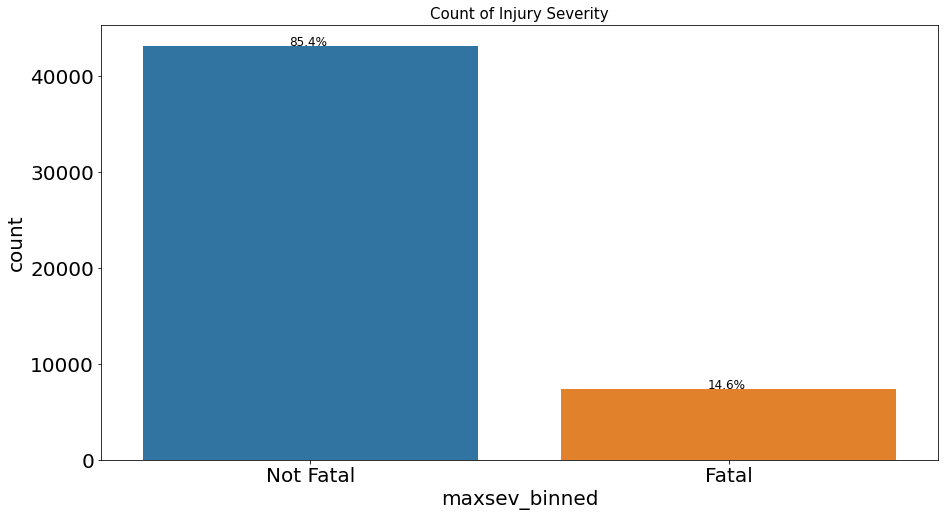

In [192]:
# Visualize class distribution. Note the imbalance that will be addressed later: not fatal 85% vs. fatal 15%
# https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

plt.figure(figsize = (15,8));
ax = sns.countplot('maxsev_binned', data=df)
without_hue(ax, df.maxsev_binned)
plt.title('Count of Injury Severity', fontsize=15);

#### **Response variable for task 2:** Age

EDA:
- Right skewed
- Age ranges from 16-120, with mean age of 40, median of 35, and IQR of 27 years old. 
- This aligns with what we know about legal driving age, working age, and retirement age.
- View summary statistics and distribution below

          count       mean        std   min   25%   50%   75%    max
age_im  50535.0  39.552548  17.556665  16.0  25.0  35.0  52.0  120.0


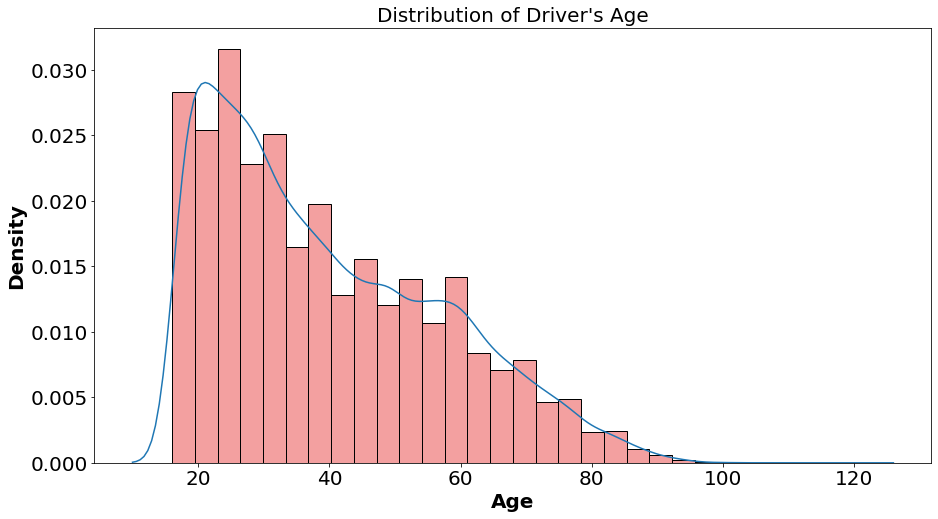

In [193]:
# Visualize age summary statistics
print(df[['age_im']].describe().T)

# Visualize age distribution
plt.figure(figsize = (15,8));
sns.histplot(df, x = "age_im", bins=30,  stat="density", color ='lightcoral');
sns.kdeplot(data=df, x = "age_im");
plt.xlabel('Age', weight = 1000, size=20)
plt.ylabel('Density', weight = 1000, size=20)
plt.title("Distribution of Driver's Age", size=20);

### End of data cleaning. Review final dataset

In [194]:
# Remove features that are not useful for modeling or redundant post binning
# Recall from summary those features are:
#  - `makename` (too many levels)
#  - `wrk_zonename` (99% of one class)
#  - `hour_imname` (unnecessary with `hour_binned`)
#  - `vspd_lim` (unnecessary with `speeding_status`) 
#  - `body_type_x` (unnecessary with `body_type_binned`)
#  - `weathername` (unecessary with `weather_binned`)
#  - `typ_intname` (unnecessary with `intersection_binned`)
#  - `maxsev_imname` (unnecessary with `maxsev_binned`)
#  - `trav_sp` (unnecessary with `trav_sp_imputed`) this will be removed later after imputation

df = df[df.columns.difference(['body_typname_x', 'typ_intname', 'weathername', 'rest_usename', 'hour_imname', 'vspd_lim'])]

In [195]:
# Check for duplicates
# Recall duplicated casenum was taken cared of during merge
# Here we check for duplicates of instances excluding `casenum`
df.duplicated().sum()

0

In [196]:
# Confirm there are zero NA values
df.isnull().sum().sum()

0

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50535 entries, 0 to 54471
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50535 non-null  int64  
 1   alchl_imname         50535 non-null  object 
 2   body_type_binned     50535 non-null  object 
 3   hour_binned          50535 non-null  object 
 4   int_hwyname          50535 non-null  object 
 5   intersection_binned  50535 non-null  object 
 6   lgtcon_imname        50535 non-null  object 
 7   maxsev_binned        50535 non-null  object 
 8   maxsev_imname        50535 non-null  object 
 9   mod_yearname_x       50535 non-null  int64  
 10  pcrash1_imname       50535 non-null  object 
 11  regionname           50535 non-null  object 
 12  reljct1_imname       50535 non-null  object 
 13  restraint_binned     50535 non-null  object 
 14  sex_imname           50535 non-null  object 
 15  speeding_status      50535 non-null 

In [209]:
df.head()

,age_im,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,mod_yearname_x,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,1,Morning,No,Yes,Daylight,Not Fatal,No Apparent Injury,2018,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known whether or not Pedestrian Signal,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,1,Night,No,No,Dark - Not Lighted,Not Fatal,Suspected Minor Injury,2013,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,2,Afternoon,Yes,No,Daylight,Not Fatal,No Apparent Injury,2015,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
4,23,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,No Apparent Injury,2004,...,Male,unknown,998.0,Rural,NR/UNK,Snow,Warning Sign,NR/UNK,Wintery,Wednesday
5,57,No Alcohol Involved,3,Evening,No,No,Dark - Not Lighted,Not Fatal,Possible Injury,2003,...,Female,unknown,998.0,Rural,NR/UNK,Dry,No Controls,NR/UNK,Clear,Wednesday


In [210]:
# Summary statistics of continuous variables
# Ignore trav_sp because of indicator values e.g., 999 represents speed reported as unknown
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age_im,50535.0,39.552548,17.556665,16.0,25.0,35.0,52.0,120.0
mod_yearname_x,50535.0,2010.730167,6.848490,1980.0,2006.0,2012.0,2017.0,2021.0
trav_sp,50535.0,583.428930,479.172085,0.0,35.0,998.0,998.0,999.0


In [211]:
# Summary statistics of categorical variables
# This gives reader a cursory view of the average situation/environment of a typical crash
df.describe(include=[object], exclude=[np.number]).T

,count,unique,top,freq
alchl_imname,50535,2,No Alcohol Involved,46578
body_type_binned,50535,12,1,19865
hour_binned,50535,4,Evening,16566
int_hwyname,50535,2,No,45885
intersection_binned,50535,3,No,28126
lgtcon_imname,50535,7,Daylight,33942
maxsev_binned,50535,2,Not Fatal,43151
maxsev_imname,50535,5,No Apparent Injury,22490
pcrash1_imname,50535,19,Going Straight,28071
regionname,50535,4,South,26454


## Begin data preprocessing

In [212]:
# Split data 80/20 train test with 10 fold stratified cross validation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

In [213]:
# instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training set age and model year columns, and transform (scale) the training set age and model year columns
train_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.fit_transform(X=train_df.loc[:, ["age_im", "mod_yearname_x"]])

# Using means and standard deviations from training set, scale the test set
test_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.transform(X=test_df.loc[:, ["age_im", "mod_yearname_x"]])

In [214]:
# List of features to OneHotEncode
features_to_ohe = ["hour_binned", "intersection_binned", "lgtcon_imname", "pcrash1_imname", "regionname", 
                   "restraint_binned", "vtrafconname", "vtrafwayname", "weather_binned", "wkdy_imname", 
                   "vnum_lanname", "vsurcondname", "speeding_status", "body_type_binned"]

# Features that need to become binary
binary_features = ["urbanicityname", "alchl_imname", "reljct1_imname", "int_hwyname", "sex_imname"]

# List of all the features that are not being converted to binary, or being OneHotEncoder
# (Just a list of all features not in either of the two lists above).
non_encoded_features = [col for col in df.columns if col not in features_to_ohe + binary_features]

# Map each soon to be binary feature to its two initial values
binary_encoding_map = {feature:df[feature].unique().tolist() for feature in binary_features}

# Instantiate the OrdinalEncoder that will create the binary columns
ord_encoder = OrdinalEncoder(categories=[value for value in binary_encoding_map.values()])

# Map each feature that will be OneHotEncoded to a list of all possible categories that feature can take on. 
oridnal_encoding_map = {feature:df[feature].unique().tolist() for feature in features_to_ohe}

# Instantiate the OneHotEncoder, telling it what the possible categories are for each feature.
oh_encoder = OneHotEncoder(categories=[value for value in oridnal_encoding_map.values()]) 

encoders = ColumnTransformer(transformers=[("ordinal_encoder", ord_encoder, binary_features), 
                                           ("one_hot_encoder", oh_encoder, features_to_ohe)], 
                             remainder="passthrough",
                             sparse_threshold=0,
                             n_jobs=-1)

# Create a dataframe of all the encoded columns in the training set
train_encoded_features = pd.DataFrame(encoders.fit_transform(train_df.drop(columns=non_encoded_features)), 
                                      columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the training set where all columns that need to be encoded are now encoded.
train_encoded_df = pd.concat(objs=[train_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   train_encoded_features.reset_index(drop=True)], 
                             axis='columns')

# Create a dataframe of all encoded (one hot and ordinal) columns for the test set
test_encoded_features = pd.DataFrame(encoders.transform(test_df.drop(columns=non_encoded_features)), 
                                     columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the test set where all columns that need to be encoded are now encoded.
test_encoded_df = pd.concat(objs=[test_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   test_encoded_features.reset_index(drop=True)], 
                             axis='columns')

#### Imputing travel speed

In [215]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Set the placeholder values (which need to be imputed) to NaN
train_encoded_df.loc[train_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan
test_encoded_df.loc[test_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan

# Set up version of training dataset to be used for imputing trav_sp
imputer_train_df = train_encoded_df.copy(deep=True)
imputer_train_df.drop(columns=["maxsev_binned"], inplace=True)
severity_ord_enc = OrdinalEncoder(categories=[["No Apparent Injury", "Possible Injury", "Suspected Minor Injury", "Suspected Serious Injury", "Fatal Injury"]])
imputer_train_df["maxsev_imname"] = severity_ord_enc.fit_transform(X=imputer_train_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Setting the minimum and maximum value the imputer can impute for a traveling speed. 
min_trav_sp = 15
max_trav_sp = 151
impute_min_values = [-np.inf if col != "trav_sp" else min_trav_sp for col in imputer_train_df.columns]
impute_max_values = [np.inf if col != "trav_sp" else max_trav_sp for col in imputer_train_df.columns]

# Instantiate the iterative imputer
imputer = IterativeImputer(min_value=impute_min_values, 
                           max_value=impute_max_values,
                           random_state=42)

# Fit the iterative imputer on the training set, and impute the training set
imputer_train_result = imputer.fit_transform(X=imputer_train_df)

# Take the output of running iteratrive imputer on the train set, and convert it to a dataframe
# Save the imputed version of traveling speed to train_encoded_df
imputer_train_result_df = pd.DataFrame(imputer_train_result, 
                                       columns=imputer.get_feature_names_out())
train_encoded_df["trav_sp_imputed"] = imputer_train_result_df["trav_sp"]

# Set up the version of the test dataset that will run through the imputer
imputer_test_df = test_encoded_df.copy(deep=True)
imputer_test_df.drop(columns=["maxsev_binned"], inplace=True)
imputer_test_df["maxsev_imname"] = severity_ord_enc.transform(X=imputer_test_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Run the test data through the imputer
imputer_test_result = imputer.transform(X=imputer_test_df)

# Convert the output of running the test data through iterative imputer to a dataframe
imputer_test_result_df = pd.DataFrame(imputer_test_result, 
                                      columns=imputer.get_feature_names_out())
test_encoded_df["trav_sp_imputed"] = imputer_test_result_df["trav_sp"]

In [216]:
# Remove maxsev_imname from all dataframes
df.drop(columns="maxsev_imname", inplace=True)

# Dropping the Non-Imputed versions of travel speed, now that imputation has been performed
train_imputed_df = train_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])
test_imputed_df = test_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])

#### Scaling travel speed

In [217]:
speed_scaler = StandardScaler()

# Fit and transform the scaler on the training set
train_imputed_df["trav_sp_scaled"] = speed_scaler.fit_transform(train_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Only transform on the test set (no data leakage)
test_imputed_df["trav_sp_scaled"] = speed_scaler.transform(test_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Use these dataframes moving forward
# The final, fully preprocessed dataframes (all features encoded and imputed as needed)
# Using "pp" to stand for preprocessed
train_pp_df = train_imputed_df.drop(columns="trav_sp_imputed")
test_pp_df = test_imputed_df.drop(columns="trav_sp_imputed")

### Visualize Variable Representation

In [218]:
pd.set_option('display.max_rows', None)
table = [
    ['age_im', 'int'],
    ['maxsev_binned', 'object'],
    ['mod_yearname_x', 'int'],
    ['ordinal_encoder__urbanicityname', 'ordinal encoded'],
    ['ordinal_encoder__alchl_imname', 'ordinal encoded'],
    ['ordinal_encoder__reljct1_imname', 'ordinal encoded'],
    ['ordinal_encoder__int_hwyname', 'ordinal encoded'],
    ['ordinal_encoder__sex_imname', 'ordinal encoded'],
    ['one_hot_encoder__hour_binned_Morning', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Night', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Afternoon', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Evening', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_Yes', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_No', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_Other','one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Daylight', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Not Lighted', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dawn', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Lighted', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Unknown Lighting', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dusk', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Other', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Going Straight', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Negotiating a Curve', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Stopped in Roadway', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Turning Right', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Turning Left', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Starting in Road', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Changing Lanes', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Decelerating in Road', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Passing or Overtaking Another Vehicle', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Backing Up (other than for Parking Position)', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Making a U-turn', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Accelerating in Road', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Disabled or "Parked" in Travel lane', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Leaving a Parking Position', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Merging', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Entering a Parking Position', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Other(specify:)', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Successful Avoidance Maneuver to a Previous Critical Event', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_No Driver Present / Unknown if Driver Present', 'one hot encoded'],
    ['one_hot_encoder__regionname_West' 'one_hot_encoder__regionname_South', 'one hot encoded'],
    ['one_hot_encoder__regionname_Northeast', 'one hot encoded'],
    ['one_hot_encoder__regionname_Midwest', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Full', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Other', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_None', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Minimal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal(on colors) not known whether or not Pedestrian Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_No Controls', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Warning Sign', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_NR/UNK/OTH', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Stop Sign', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal (on colors) without Pedestrian Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal (on colors) with Pedestrian Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Railway Crossing Device', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Yield Sign', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Flashing Traffic Control Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Person', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_School Zone Sign/Device', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Lane Use Control Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Not Divided', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way,  Divided, Positive  Median Barrier', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_NR/UNK', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Entrance/Exit Ramp', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Divided, Unprotected Median', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_One-Way Trafficway', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Not Divided With a Continuous Left-Turn Lane', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Non-Trafficway or Driveway Access', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Not Clear', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Clear', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Wintery', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Other', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Rain', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Windy', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Wednesday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Friday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Thursday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Saturday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Sunday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Monday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Tuesday', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Five lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Two lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_NR/UNK', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Three lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Four lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Six lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Non-Trafficway or Driveway Access', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Seven or more lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_One lane', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Snow', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Dry', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_NR/UNK/OTH', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Wet', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Non-Trafficway or Driveway Access', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Ice/Frost', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Water (Standing or Moving)', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Slush', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Sand', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Mud, Dirt or Gravel', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Oil', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_unknown', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_speeding', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_not speeding', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_1', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_2', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_6', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_3', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_9', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_12', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_7', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_10', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_4', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_11', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_5', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_8', 'one hot encoded'],
    ['trav_sp_scaled', 'float']
]
table = pd.DataFrame(table, columns=['Variable', 'Representation'])
table

,Variable,Representation
0,age_im,int
1,maxsev_binned,object
2,mod_yearname_x,int
3,ordinal_encoder__urbanicityname,ordinal encoded
4,ordinal_encoder__alchl_imname,ordinal encoded
5,ordinal_encoder__reljct1_imname,ordinal encoded
6,ordinal_encoder__int_hwyname,ordinal encoded
7,ordinal_encoder__sex_imname,ordinal encoded
8,one_hot_encoder__hour_binned_Morning,one hot encoded
9,one_hot_encoder__hour_binned_Night,one hot encoded


In [219]:
pd.reset_option("display.max_rows")

### Feature Selection

This was conducted through three different feature importance methods: Random Forest, SelectKBest, and Mutual Information.

The three plots below depict the important features in descending order. We've highlighted the top 6 from each method.

**Random Forest:**
1. Car's traveling speed
2. Driver's age
3. Year of vehicle
4. Restraint use (None, Full)
5. Driver's alcohol status
6. Vehicle's body type (1)


**SelectKBest:**
1. Restraint use (None, Full)
2. Car's traveling speed
3. Driver's alcohol status
4. Vehicle's body type (5)
5. Hour of accident (Night)
6. Lighting condition at the time of accident (Daylight)

**Mutual Information:**
1. Restraint use (None, Full)
2. Driver's alcohol status
3. Hour of accident (Night)
4. Vehicle's body type (5)
6. Driver's speeding status (Speeding)

**Mutual Information: Regression**
1) Body Type: Sedan
2) Travel Speed
3) Hour Binned: Night
4) Light Condition Daytime
5) Body Type: Truck

In summary, the overlapping features were restraint use, body type, alcohol use, hour of accident, travel speed, whether driver was speeding, and lighting condition. This aligned with our intuition that injury severity is most likely affected by speed, alcohol, restraint use, and lighting (natural or artificial). Body type is an intriguing feature that we did not expect to see here. We will note that most of the features in the top 20 were from careful binning and newly added/derived features. Lastly, it is interesting to see random forest chose all continuous variables first. For our target class of age, the feature that made the most sense was travel speed for predicting. The other four features may be due to an over representation in the dataset. 

In summary, the overlapping features were restraint use, body type, alcohol use, hour of accident, travel speed, whether driver was speeding, and lighting condition. This aligned with our intuition that injury severity is most likely affected by speed, alcohol, restraint use, and lighting (natural or artificial). Body type is an intriguing feature that we did not expect to see here. We will note that most of the features in the top 20 were from careful binning and newly added/derived features. Lastly, it is interesting to see random forest chose all continuous variables first.

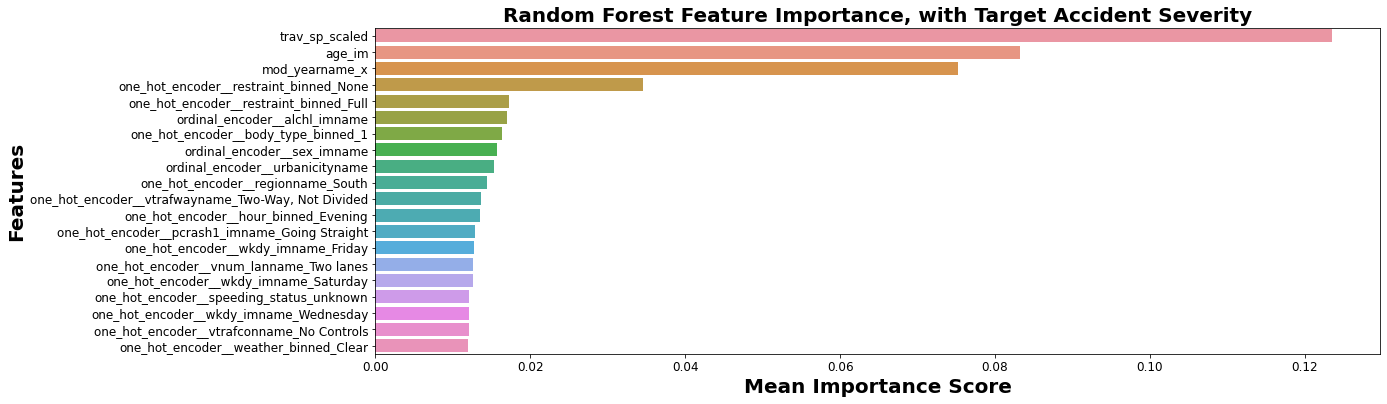

In [220]:
# code for feature selection: random forest feature importance

# We will plot importances for the top NUM_IMPORTANCES_TO_PLOT features (by mean score)
# This will be used for rf, selectkbest and mutualinfo
NUM_IMPORTANCES_TO_PLOT = 20

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Calculates the standard deviation of the importance score for each feature.
# For each of the 100 trees in the random forest, get the importance scores for all 106 features.
# Then take the standard deviation of those 100 scores for each of the 106 features.
# Result is 106 standard deviations, where each standard deviation was calculated from 100 values. 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
rf_importance_stds = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create a dataframe of importance scores
rf_importances_df = pd.DataFrame({"feature_name":rf.feature_names_in_, 
                                  "mean_importance_score":rf.feature_importances_, 
                                  "std_importance_score":rf_importance_stds})

# Sort the dataframe, largest to smallest mean score
rf_importances_df.sort_values(by="mean_importance_score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
rf_importances_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
rf_plot_df = rf_importances_df.loc[rf_importances_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="mean_importance_score", data=rf_plot_df, ax=ax, orient="h")

ax.set_title("Random Forest Feature Importance, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Mean Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

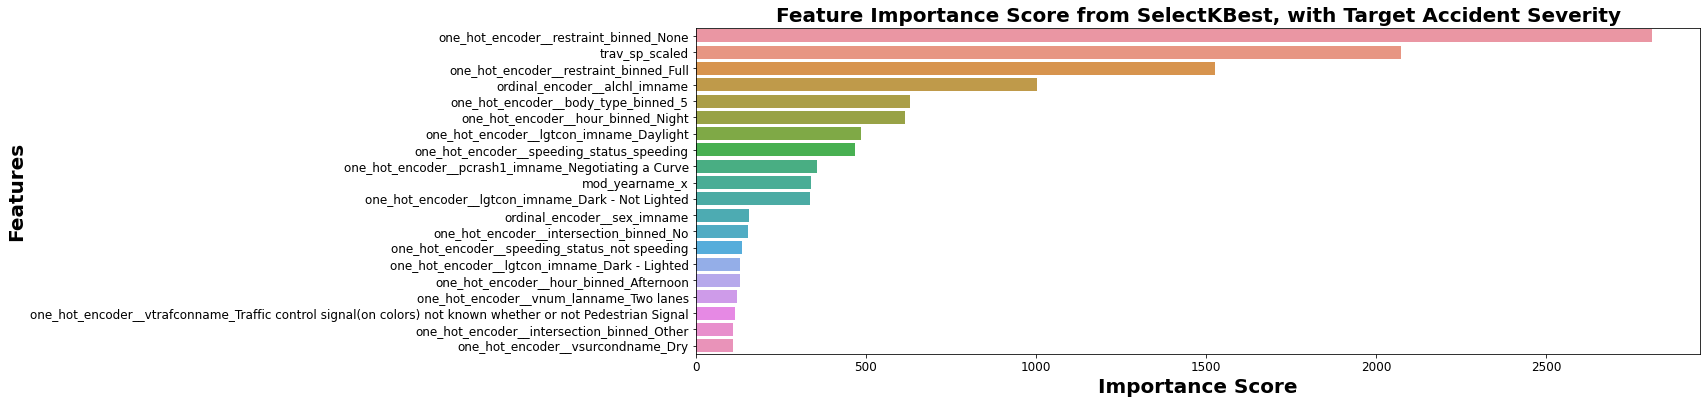

In [221]:
# code for feature selection: selectkbest

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the random forest classifier
kselector = SelectKBest(k=NUM_IMPORTANCES_TO_PLOT)
kselector.fit(X, y)

# Create a dataframe of scores
kbest_scores_df = pd.DataFrame({"feature_name":kselector.feature_names_in_, 
                                  "score":kselector.scores_, 
                                  "p_value":kselector.pvalues_})


# Sort the dataframe, largest to smallest mean score
kbest_scores_df.sort_values(by="score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
kbest_scores_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
kbest_plot_df = kbest_scores_df.loc[kbest_scores_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="score", data=kbest_plot_df, ax=ax, orient="h")

ax.set_title("Feature Importance Score from SelectKBest, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

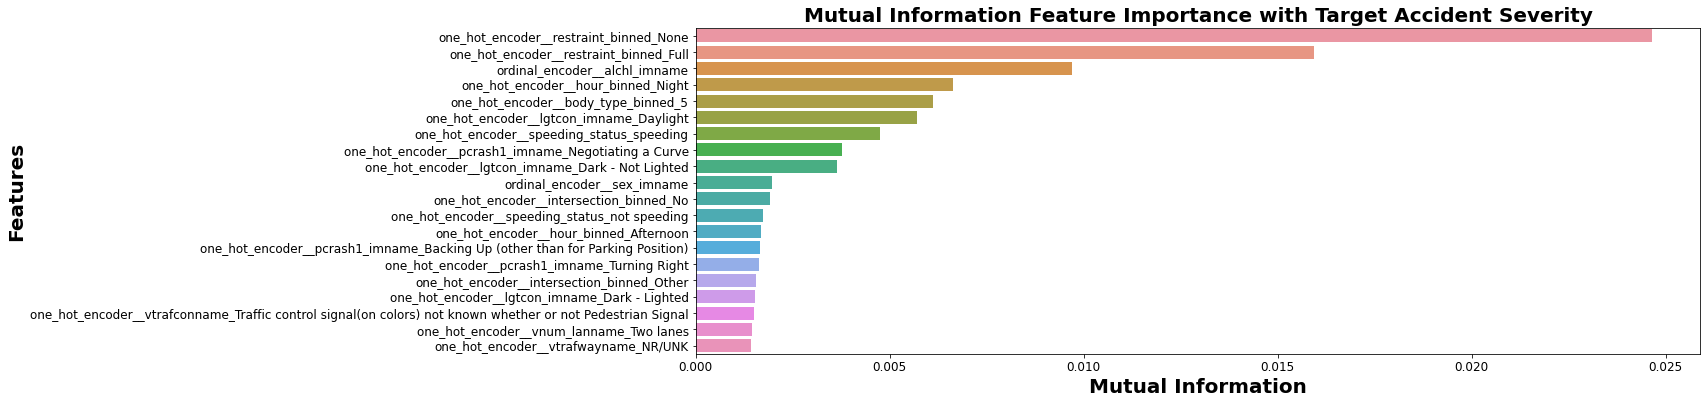

In [222]:
# code for feature selection: mutual information

# NOTE: mutual info is only considering discrete features

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned", "age_im", "mod_yearname_x", "trav_sp_scaled"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the mutual information module
mutual_info = mutual_info_classif(X=X, y=y, discrete_features=True, n_neighbors=3, random_state=42)

# Create a dataframe of scores
mutual_info_df = pd.DataFrame({"mutual_information":mutual_info, 
                               "feature_name":X.columns.tolist()})

# Sort the dataframe, largest to smallest score
mutual_info_df.sort_values(by="mutual_information", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
mutual_info_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
mutual_info_plot_df = mutual_info_df.loc[mutual_info_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="mutual_information", data=mutual_info_plot_df, ax=ax, orient="h")

ax.set_title("Mutual Information Feature Importance with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Mutual Information", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

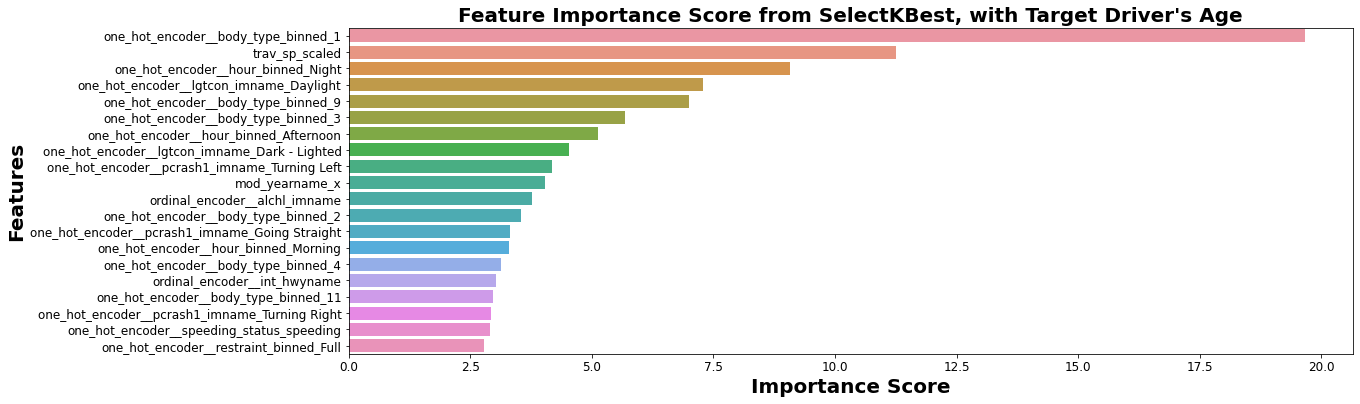

In [223]:
##One hot encode maxsev
sev_temp=train_pp_df.maxsev_binned
sev_temp=sev_temp.values.reshape(-1,1)
sev_temp_ohe=OneHotEncoder(sparse=False).fit(sev_temp)
train_pp_df[sev_temp_ohe.categories_[0]]=sev_temp_ohe.transform(sev_temp)
X = train_pp_df.drop(columns=["age_im", "maxsev_binned"])
y= scaler.inverse_transform(train_pp_df.loc[:, ["age_im", "mod_yearname_x"]])[:,0]
# Instantiate and fit the random forest classifier
kselector = SelectKBest(k=NUM_IMPORTANCES_TO_PLOT)
kselector.fit(X, y)

# Create a dataframe of scores
kbest_scores_df = pd.DataFrame({"feature_name":kselector.feature_names_in_, 
                                  "score":kselector.scores_, 
                                  "p_value":kselector.pvalues_})


# Sort the dataframe, largest to smallest mean score
kbest_scores_df.sort_values(by="score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
kbest_scores_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
kbest_plot_df = kbest_scores_df.loc[kbest_scores_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="score", data=kbest_plot_df, ax=ax, orient="h")

ax.set_title("Feature Importance Score from SelectKBest, with Target Driver's Age", fontsize=20, weight=1000)
ax.set_xlabel("Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

# Data Preparation Part 2
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
(5)

- The original dataset (after initial merging and filtering) consisted of 54,473 observations and 24 columns.
- After caring for NA values and further preprocessing (filter, bin, impute, scale, one-hot encode), the final dataset concluded with 50,535 observations and 119 columns.
- Friendly reminder that our dataset was split 80/20 train/test (with 10-fold internal cross validation)
- Below is a description of the newly formed or binned variables.
- Below is display() call of the **clean** dataframe prior to preprocessing (50535 rows × 23 columns)
- Below is display() call of **train** dataframe after preprocessing (40428 rows × 119 columns)
- Below is display() call of **test** dataframe after preprocessing (10107 rows × 119 columns)
- Friendly reminder that our classification task is to predict accident severity, `maxsev_binned`
- Friendly reminder that our regression task is to predict age, `age_im`

In [224]:
pd.set_option('max_colwidth', None)
data = [
    ['restraint_binned', 'Object/Categorical', 'Restraint equipment used by driver', 'Full, Minimal, None, Other (one hot encoded)'],
    ['pcrash1_imname', 'Object/Categorical', "Driver's pre-event movenent prior to recognition of critical event", '19 (one hot encoded)'],
    ['speeding_status', 'Object/Categorical', 'Whether driver was above or below speeding limit', 'Speeding, Not Speeding, Unknown (one hot encoded)'],
    ['hour_binned', 'Object/Categorical', 'Time of accident', 'Morning (6am-noon), afternoon (noon-6pm), evening (6pm-midnight), night (midnight-6am) (one hot encoded)'],
    ['body_type_binned', 'Object/Categorical', 'Body type of vehicle', '12 (one hot encoded)'],
    ['weather_binned', 'Object/Categorical', 'Weather at time of accident', 'Clear, Not Clear, Rain, Wintery, Windy, Other (one hot encoded)'],
    ['trav_sp_imputed', 'Int/Numerical', 'Traveling speed of the car', '-'],
    ['intersection_binned', 'Object/Categorical', 'Whether accident took place at an intersection', 'Yes,  No, Other (one hot encoded'],
    ['maxsev_binned', 'Object/Categorical', 'Severity of injury sustained by the driver', 'Fatal, Not Fatal']
]
data = pd.DataFrame(data, columns=[['Feature Name', 'Datatype', 'Description', 'Levels, if applicable']])
data

,Feature Name,Datatype,Description,"Levels, if applicable"
0,restraint_binned,Object/Categorical,Restraint equipment used by driver,"Full, Minimal, None, Other (one hot encoded)"
1,pcrash1_imname,Object/Categorical,Driver's pre-event movenent prior to recognition of critical event,19 (one hot encoded)
2,speeding_status,Object/Categorical,Whether driver was above or below speeding limit,"Speeding, Not Speeding, Unknown (one hot encoded)"
3,hour_binned,Object/Categorical,Time of accident,"Morning (6am-noon), afternoon (noon-6pm), evening (6pm-midnight), night (midnight-6am) (one hot encoded)"
4,body_type_binned,Object/Categorical,Body type of vehicle,12 (one hot encoded)
5,weather_binned,Object/Categorical,Weather at time of accident,"Clear, Not Clear, Rain, Wintery, Windy, Other (one hot encoded)"
6,trav_sp_imputed,Int/Numerical,Traveling speed of the car,-
7,intersection_binned,Object/Categorical,Whether accident took place at an intersection,"Yes, No, Other (one hot encoded"
8,maxsev_binned,Object/Categorical,Severity of injury sustained by the driver,"Fatal, Not Fatal"


In [225]:
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50535 entries, 0 to 54471
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50535 non-null  int64  
 1   alchl_imname         50535 non-null  object 
 2   body_type_binned     50535 non-null  object 
 3   hour_binned          50535 non-null  object 
 4   int_hwyname          50535 non-null  object 
 5   intersection_binned  50535 non-null  object 
 6   lgtcon_imname        50535 non-null  object 
 7   maxsev_binned        50535 non-null  object 
 8   mod_yearname_x       50535 non-null  int64  
 9   pcrash1_imname       50535 non-null  object 
 10  regionname           50535 non-null  object 
 11  reljct1_imname       50535 non-null  object 
 12  restraint_binned     50535 non-null  object 
 13  sex_imname           50535 non-null  object 
 14  speeding_status      50535 non-null  object 
 15  trav_sp              50535 non-null 

In [227]:
display(df)

,age_im,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,mod_yearname_x,pcrash1_imname,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,1,Morning,No,Yes,Daylight,Not Fatal,2018,Going Straight,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known whether or not Pedestrian Signal,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,1,Night,No,No,Dark - Not Lighted,Not Fatal,2013,Going Straight,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,2,Afternoon,Yes,No,Daylight,Not Fatal,2015,Going Straight,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
4,23,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,2004,Negotiating a Curve,...,Male,unknown,998.0,Rural,NR/UNK,Snow,Warning Sign,NR/UNK,Wintery,Wednesday
5,57,No Alcohol Involved,3,Evening,No,No,Dark - Not Lighted,Not Fatal,2003,Going Straight,...,Female,unknown,998.0,Rural,NR/UNK,Dry,No Controls,NR/UNK,Clear,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54467,61,No Alcohol Involved,2,Afternoon,No,No,Daylight,Not Fatal,2017,Going Straight,...,Female,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Monday
54468,70,No Alcohol Involved,3,Evening,No,No,Daylight,Not Fatal,2019,Going Straight,...,Male,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Not Clear,Wednesday
54469,59,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,1999,Negotiating a Curve,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Thursday
54470,67,No Alcohol Involved,3,Morning,No,No,Daylight,Not Fatal,2006,Going Straight,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Tuesday


In [228]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 80% TRAIN DATAFRAME (40428 rows × 119 columns)
# Due to the extensive columns after hot encoding, 
# please refer to Visualize Variable Representation above for the full list of columns
# Note 119 entries in this call corresponds to 119 columns in the display() call above
train_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428 entries, 0 to 40427
Columns: 121 entries, age_im to Not Fatal
dtypes: float64(120), object(1)
memory usage: 37.3+ MB


In [229]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 80% TRAIN DATAFRAME (40428 rows × 119 columns)
display(train_pp_df)

,age_im,maxsev_binned,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,one_hot_encoder__hour_binned_Night,...,one_hot_encoder__body_type_binned_12,one_hot_encoder__body_type_binned_7,one_hot_encoder__body_type_binned_10,one_hot_encoder__body_type_binned_4,one_hot_encoder__body_type_binned_11,one_hot_encoder__body_type_binned_5,one_hot_encoder__body_type_binned_8,trav_sp_scaled,Fatal,Not Fatal
0,2.530925,Not Fatal,0.625929,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573139,0.0,1.0
1,0.194944,Not Fatal,-2.002092,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040888,0.0,1.0
2,1.961173,Not Fatal,0.771930,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.929556,0.0,1.0
3,0.365870,Not Fatal,1.063933,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.775295,0.0,1.0
4,-0.602708,Not Fatal,-0.396079,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272600,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40423,0.536795,Not Fatal,0.479928,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.376373,0.0,1.0
40424,0.479820,Not Fatal,1.355935,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.573139,0.0,1.0
40425,-0.773633,Fatal,-1.418087,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.599395,1.0,0.0
40426,-0.032956,Not Fatal,1.063933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.929556,0.0,1.0


In [230]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 20% TEST DATAFRAME (10107 rows × 119 columns)
# Due to the extensive columns after hot encoding, 
# please refer to Visualize Variable Representation above for the full list of columns
# Note 119 entries in this call corresponds to 119 columns in the display() call above
test_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10107 entries, 0 to 10106
Columns: 119 entries, age_im to trav_sp_scaled
dtypes: float64(118), object(1)
memory usage: 9.2+ MB


In [231]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 20% TEST DATAFRAME (10107 rows × 119 columns)
display(test_pp_df)

,age_im,maxsev_binned,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,one_hot_encoder__hour_binned_Night,...,one_hot_encoder__body_type_binned_3,one_hot_encoder__body_type_binned_9,one_hot_encoder__body_type_binned_12,one_hot_encoder__body_type_binned_7,one_hot_encoder__body_type_binned_10,one_hot_encoder__body_type_binned_4,one_hot_encoder__body_type_binned_11,one_hot_encoder__body_type_binned_5,one_hot_encoder__body_type_binned_8,trav_sp_scaled
0,-0.032956,Not Fatal,-0.396079,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.376716
1,1.334447,Not Fatal,1.063933,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.929556
2,0.878646,Not Fatal,-0.834082,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.530635
3,-1.001534,Not Fatal,0.917932,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.925151
4,0.422845,Not Fatal,1.063933,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.629017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10102,-0.716658,Fatal,-0.834082,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.152092
10103,-0.602708,Not Fatal,1.063933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.622488
10104,2.758825,Fatal,0.771930,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.923350
10105,0.422845,Not Fatal,-0.396079,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272600


# Model and Evaluation 1
- Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). 
- Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
(10)

## Accident Severity Classification
The evaluation metric used to classify accident severity is F1. This is an appropriate metric because the response, maximum severity, is a categorical variable. Due to the class imbalance (85.38% Non-Fatal, 14.12% Fatal, an assertion backed-up by the value counts call below), metrics such as accuracy is not desirable because the model could have a high no-information-rate i.e., choose the most populous category and be correct most of the time. F1 is the harmonic mean between precision and recall and is much more conducive to discerning the model's performance because it requires high precision and high recall. A high F1 indicates better predictive performance.

## Age Regression
The evaluation metric used to classify driver's age is MSE (mean squared error). This is an appropriate metric because the response, age, is a continuous variable. MSE is calculated as the average of the *squared* errors (differences between the true and predicted values) and as such large errors lend to larger penalty. It aims to measure the variance between residuals, thus making it a solid validation metric. A low MSE indicates better predictive performance.

In [232]:
# Evidence of imbalanced classes
df['maxsev_binned'].value_counts(normalize=True)

Not Fatal    0.853883
Fatal        0.146117
Name: maxsev_binned, dtype: float64

# Model and Evaluation 2
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). 
- Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
(10)

## Accident Severity Classification
The cleaned dataset was split into 80/20 train/test then proceeded with stratified 10 fold internal cross validation due to the class imbalance of injury severity (85% not fatal, 15% fatal). k-fold assumes a uniform probablity distribution, however in an imbalanced class, it is highly likely that most folds heavily lack representation of the class with lower count, fatal in this model. In which case, the model will predict the majority class thus resulting in a misleading, highly optimistic confusion matrix. Stratified k-fold cross validation mitigates this problem by matching the training data distribution and imposing equal class representation in each fold to produce a more realistic indication of model performance.

## Age Regression
We note that the distribution of age was right skewed. In datasets with a small sample size, the normality assumption is violated thus stratified sampling makes sense to partition age and randomly sample from each segment. However, our dataset consisted of a large sample size (50,000+) in conjucntion with the central limit theorem, we were not concerned with deviations from normality. A simple 80% train/20% test split would have sufficed. We ultimately proceeded with stratified 10 fold cross validation to be consistent with the classification model.

In [85]:
# The code to split the data was ran in the previous section but for completeness, it is pasted below
# Split data 80/20 train test with 10 fold stratified cross validation
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

In [233]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 80% TRAIN DATAFRAME (40428 rows × 119 columns)
# Due to the extensive columns after hot encoding, 
# please refer to Visualize Variable Representation above for the full list of columns
# Note 119 entries in this call corresponds to 119 columns in the display() call above
train_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428 entries, 0 to 40427
Columns: 121 entries, age_im to Not Fatal
dtypes: float64(120), object(1)
memory usage: 37.3+ MB


In [234]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 80% TRAIN DATAFRAME (40428 rows × 119 columns)
display(train_pp_df)

,age_im,maxsev_binned,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,one_hot_encoder__hour_binned_Night,...,one_hot_encoder__body_type_binned_12,one_hot_encoder__body_type_binned_7,one_hot_encoder__body_type_binned_10,one_hot_encoder__body_type_binned_4,one_hot_encoder__body_type_binned_11,one_hot_encoder__body_type_binned_5,one_hot_encoder__body_type_binned_8,trav_sp_scaled,Fatal,Not Fatal
0,2.530925,Not Fatal,0.625929,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573139,0.0,1.0
1,0.194944,Not Fatal,-2.002092,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040888,0.0,1.0
2,1.961173,Not Fatal,0.771930,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.929556,0.0,1.0
3,0.365870,Not Fatal,1.063933,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.775295,0.0,1.0
4,-0.602708,Not Fatal,-0.396079,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272600,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40423,0.536795,Not Fatal,0.479928,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.376373,0.0,1.0
40424,0.479820,Not Fatal,1.355935,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.573139,0.0,1.0
40425,-0.773633,Fatal,-1.418087,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.599395,1.0,0.0
40426,-0.032956,Not Fatal,1.063933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.929556,0.0,1.0


In [235]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 20% TEST DATAFRAME (10107 rows × 119 columns)
# Due to the extensive columns after hot encoding, 
# please refer to Visualize Variable Representation above for the full list of columns
# Note 119 entries in this call corresponds to 119 columns in the display() call above
test_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10107 entries, 0 to 10106
Columns: 119 entries, age_im to trav_sp_scaled
dtypes: float64(118), object(1)
memory usage: 9.2+ MB


In [236]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 20% TEST DATAFRAME (10107 rows × 119 columns)
display(test_pp_df)

,age_im,maxsev_binned,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,one_hot_encoder__hour_binned_Night,...,one_hot_encoder__body_type_binned_3,one_hot_encoder__body_type_binned_9,one_hot_encoder__body_type_binned_12,one_hot_encoder__body_type_binned_7,one_hot_encoder__body_type_binned_10,one_hot_encoder__body_type_binned_4,one_hot_encoder__body_type_binned_11,one_hot_encoder__body_type_binned_5,one_hot_encoder__body_type_binned_8,trav_sp_scaled
0,-0.032956,Not Fatal,-0.396079,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.376716
1,1.334447,Not Fatal,1.063933,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.929556
2,0.878646,Not Fatal,-0.834082,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.530635
3,-1.001534,Not Fatal,0.917932,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.925151
4,0.422845,Not Fatal,1.063933,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.629017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10102,-0.716658,Fatal,-0.834082,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.152092
10103,-0.602708,Not Fatal,1.063933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.622488
10104,2.758825,Fatal,0.771930,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.923350
10105,0.422845,Not Fatal,-0.396079,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272600


# Model and Evaluation 3
- Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). 
- Two modeling techniques must be new (but the third could be SVM or logistic regression). 
- Adjust parameters as appropriate to increase generalization performance using your chosen metric. 
- You must investigate different parameters of the algorithms!
(20)

## Section Summary

SKL's RandomizedSearchCV was utilized for the six models listed below along with corresponding adjusted hyperparameters.

**Accident Severity Classification**
1. LightGBM: 

    num_leaves (21, 26, 31, 36, 41)  
    max_depth (-1, 10)  
    learning_rate (0.01, 0.05, 0.1, 0.15, 0.2, 0.3)  
    `Best LightGBM model parameters: 'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.3`

2. Random Forest:   

    n_estimators (100, 300)  
    max_depth (None, 10, 11, 12, 13, 14, 15)  
    min_samples_split (2, 5, 10)  
    min_samples_leaf (1, 2, 3)  
    `Best random forest model parameters:` 

    
3. kNN

    Odd values of K between 3 and 101  
    `Best kNN model parameters:` 

**Age Regression**
1. Random Forest  

    n_estimators (100, 300)  
    max_depth (None, 10, 11, 12, 13, 14, 15)  
    min_samples_split (2, 5, 10)  
    min_samples_leaf (1, 2, 3)   
    `Best random forest model parameters: 'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None`
2. kNN  

    odd values of K between 5 and 101  
    metric (euclidean, manhattan, chebyshev)  
    `Best kNN model parameters: 'n_neighbors': 7, 'metric': 'chebyshev'`
    
3. SGD  

    Penalty (l1, l2, elasticnet)  
    learning_rate (constant, optimal, adaptive, invscaling)  
    `Best SGDR model parameters: 'penalty': 'elasticnet', 'learning_rate': 'optimal'`


## Accident Severity Classification

### LightGBM for Classification

In [86]:
%%time

# Split the train set into X and y
# The extra .rename() is only because LightGBM didn't like some of the characters in the column names. (brackets)
# https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
X = train_pp_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)).drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

param_distributions = {'num_leaves':[21, 26, 31, 36, 41], 
                       'max_depth':[-1, 10], 
                       'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]}

rs_severity_lgbm_clf = RandomizedSearchCV(estimator=LGBMClassifier(boosting_type="gbdt", random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_lgbm_clf.fit(X, y)

lgbm_rs_severity_df = pd.DataFrame(rs_severity_lgbm_clf.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
lgbm_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in lgbm_rs_severity_df.columns if column not in first_columns]
lgbm_rs_severity_df = lgbm_rs_severity_df.loc[:, new_column_order]

# View the randomsearch results
lgbm_rs_severity_df.head()

CPU times: total: 3.84 s
Wall time: 39.4 s


,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_max_depth,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,std_train_accuracy
5,0.428939,0.716666,0.876843,0.932791,1.687197,0.560342,0.147999,0.056818,41,-1,...,0.931895,0.932032,0.932884,0.932197,0.933214,0.932307,0.933077,0.932062,0.933518,0.000839
9,0.427312,0.643011,0.877733,0.919014,2.053007,0.701767,0.169399,0.047453,31,10,...,0.919472,0.919088,0.919197,0.918648,0.917136,0.921259,0.919527,0.918100,0.917743,0.001121
7,0.404708,0.584306,0.876694,0.909405,1.324312,0.517272,0.120786,0.040499,36,10,...,0.908561,0.911337,0.910045,0.909331,0.909880,0.907984,0.910100,0.907382,0.910323,0.001123
6,0.393272,0.537383,0.876917,0.902029,2.073298,0.779933,0.145700,0.081473,36,-1,...,0.902542,0.901663,0.902185,0.902295,0.902212,0.902075,0.903037,0.900401,0.901226,0.000723
3,0.382662,0.487428,0.875012,0.893792,1.126002,0.379706,0.114798,0.043430,21,10,...,0.893995,0.894215,0.893857,0.893088,0.893528,0.895177,0.893802,0.893008,0.893448,0.000586


In [87]:
rs_severity_lgbm_clf.best_params_

{'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.3}

### Random Forest for Classification

In [88]:
%%time

X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

param_distributions = {'n_estimators':[num_trees for num_trees in range(100, 300)], 
                       'max_depth':[None, 10, 11, 12, 13, 14, 15], 
                       'min_samples_split':[2, 5, 10], 
                       'min_samples_leaf':[1, 2, 3]}

rs_severity_rf_clf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_rf_clf.fit(X, y)

rf_rs_severity_df = pd.DataFrame(rs_severity_rf_clf.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
rf_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in rf_rs_severity_df.columns if column not in first_columns]
rf_rs_severity_df = rf_rs_severity_df.loc[:, new_column_order]

# View the randomsearch results
rf_rs_severity_df.head()

CPU times: total: 36.8 s
Wall time: 8min 33s


,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,std_train_accuracy
8,0.226772,0.550839,0.865093,0.908889,55.123427,7.217824,1.109608,0.527800,166,10,...,0.909276,0.909111,0.909688,0.907984,0.908424,0.908561,0.909633,0.908399,0.909361,0.000565
1,0.222046,0.566016,0.864896,0.911244,53.421983,6.220078,1.485535,0.887640,160,5,...,0.910760,0.911612,0.911777,0.909963,0.911722,0.910485,0.911722,0.910625,0.911807,0.000675
4,0.202576,0.318559,0.864030,0.879808,61.282778,8.712317,1.262802,0.760322,264,10,...,0.880198,0.880528,0.879483,0.880005,0.878906,0.879483,0.879731,0.879652,0.880916,0.000582
5,0.202063,0.340269,0.863758,0.882444,49.307562,9.682863,0.900900,0.433811,184,10,...,0.882259,0.882809,0.882864,0.881902,0.882067,0.882671,0.882232,0.882125,0.883169,0.000389
0,0.191383,0.347738,0.863486,0.883818,36.976644,6.672097,0.853498,0.530494,170,2,...,0.882919,0.884650,0.884815,0.883331,0.883441,0.884238,0.882891,0.883746,0.884434,0.000656


In [89]:
rs_severity_rf_clf.best_params_

{'n_estimators': 166,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': None}

### kNN for Classification

In [90]:
%%time

X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Search Odd values of K between 3 and 101
param_distributions = {'n_neighbors':[num_neighbors for num_neighbors in range(3, 102) if num_neighbors % 2 != 0]}

rs_severity_knn_clf = RandomizedSearchCV(estimator=KNeighborsClassifier(), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_knn_clf.fit(X, y)

knn_rs_severity_df = pd.DataFrame(rs_severity_knn_clf.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
knn_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in knn_rs_severity_df.columns if column not in first_columns]
knn_rs_severity_df = knn_rs_severity_df.loc[:, new_column_order]

# View the randomsearch results
knn_rs_severity_df.head()

CPU times: total: 56min 43s
Wall time: 16min 1s


,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,std_train_accuracy
0,0.101174,0.116666,0.857970,0.859894,0.256898,0.060630,1.739024,0.957141,29,{'n_neighbors': 29},...,0.859805,0.859942,0.860602,0.859667,0.860245,0.859393,0.859750,0.859616,0.860523,0.000410
4,0.085121,0.100752,0.857252,0.859119,0.234601,0.025314,2.391630,0.293083,37,{'n_neighbors': 37},...,0.859090,0.859145,0.859530,0.858596,0.859283,0.859310,0.859283,0.858572,0.859726,0.000377
9,0.081260,0.095031,0.857104,0.858748,0.225482,0.010973,2.360601,0.282052,41,{'n_neighbors': 41},...,0.859145,0.858733,0.858788,0.857991,0.859090,0.858733,0.858898,0.858517,0.859039,0.000325
7,0.070609,0.080720,0.856906,0.858110,0.241699,0.016143,2.917970,0.497163,53,{'n_neighbors': 53},...,0.857991,0.858046,0.858568,0.857524,0.858651,0.857963,0.858541,0.857583,0.858599,0.000426
6,0.070365,0.079222,0.857005,0.858129,0.241599,0.022153,3.058706,0.532437,55,{'n_neighbors': 55},...,0.858018,0.857771,0.858431,0.857744,0.858513,0.858156,0.858266,0.857830,0.858847,0.000364


In [91]:
rs_severity_knn_clf.best_params_

{'n_neighbors': 29}

## Age Regression

In [92]:
##One hot encode maxsev
sev_temp=train_pp_df.maxsev_binned
sev_temp=sev_temp.values.reshape(-1,1)
sev_temp_ohe=OneHotEncoder(sparse=False).fit(sev_temp)
train_pp_df[sev_temp_ohe.categories_[0]]=sev_temp_ohe.transform(sev_temp)

### Random Forest for Regression

In [93]:
%%time

##Run RandomizedSearchCV to tune hyperparamters
##Then fit the model.

##rescale encoded values.
X = train_pp_df.drop(columns=["age_im", "maxsev_binned"])
y= scaler.inverse_transform(train_pp_df.loc[:, ["age_im", "mod_yearname_x"]])[:,0]

param_distributions = {'n_estimators':[num_trees for num_trees in range(100, 300)], 
                       'max_depth':[None, 10, 11, 12, 13, 14, 15], 
                       'min_samples_split':[2, 5, 10], 
                       'min_samples_leaf':[1, 2, 3]}

rs_age_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'MSE':make_scorer(mean_squared_error,greater_is_better=True,squared=True)}, 
                                      refit='MSE',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")
rs_age_rf.fit(X, y)

CPU times: total: 2min 5s
Wall time: 1h 16min 26s


RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 11, 12, 13, 14,
                                                      15],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 101, 102, 103,
                                                         104, 105, 106, 107,
                                                         108, 109, 110, 111,
                                                         112, 113, 114, 115,
                                                         116, 117, 118, 119,
                                                         120, 121, 122, 123,
                                                         124, 125, 126, 127,
                                                         128, 129, ...]},
                   random_state=42, refit='MSE', return_train_score=True,
                   scoring={'MSE': make_scorer(mean_squared_error, squared=True)})

In [94]:
##Print out summary of RandomizedSearch
rf_rs_age_df = pd.DataFrame(rs_age_rf.cv_results_)

# Sort the randomsearch results dataframe from lowest to highest rmse
rf_rs_age_df.sort_values(by="mean_train_MSE", ascending=True, inplace=True)
rf_rs_age_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_MSE,...,split2_train_MSE,split3_train_MSE,split4_train_MSE,split5_train_MSE,split6_train_MSE,split7_train_MSE,split8_train_MSE,split9_train_MSE,mean_train_MSE,std_train_MSE
1,599.275562,81.837456,2.715602,1.142503,160,5,2,None,"{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}",286.705346,...,74.965175,74.695820,74.704241,74.739790,74.806063,74.511136,74.434559,74.642257,74.703460,0.183423
8,370.381711,14.334538,0.724164,0.333432,166,10,1,None,"{'n_estimators': 166, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}",286.416303,...,99.889208,99.460981,99.501996,99.571188,99.575697,99.293680,99.142964,99.538086,99.518452,0.236186
5,610.298486,61.784689,1.599013,0.933442,184,10,1,15,"{'n_estimators': 184, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}",283.552690,...,202.486894,202.406216,201.268453,204.036902,204.547995,202.432316,200.856737,202.362130,202.601790,1.060339
4,751.328813,67.999408,2.873883,1.203605,264,10,2,15,"{'n_estimators': 264, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}",283.035599,...,203.645942,203.143398,201.972613,204.941062,205.212518,203.608799,201.455759,203.302404,203.386024,1.105669
0,499.481641,57.066539,0.874752,0.621482,170,2,1,13,"{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 13}",283.295603,...,216.259078,216.206209,215.448988,217.847931,218.364591,216.465005,214.965610,216.559367,216.578539,0.961881
7,261.672897,27.772537,0.688174,0.121497,165,5,2,12,"{'n_estimators': 165, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 12}",283.320896,...,233.416307,232.856021,232.769364,234.633018,235.041138,233.577701,232.005943,233.572406,233.505261,0.845569
6,507.657410,50.353299,0.939098,0.426558,234,5,1,12,"{'n_estimators': 234, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 12}",283.473379,...,234.009749,233.574069,233.059991,234.754977,235.366666,233.916989,232.369051,233.797718,233.880904,0.804883
9,159.067552,25.531191,0.164692,0.063337,126,5,2,11,"{'n_estimators': 126, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 11}",283.591860,...,246.216070,245.619808,245.655615,246.974651,247.604484,246.245848,245.030944,246.369547,246.230541,0.701593
3,681.975239,64.938396,1.299300,0.886975,291,5,3,11,"{'n_estimators': 291, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 11}",283.353636,...,247.435801,246.561233,246.518749,247.735639,248.302766,247.222457,245.651795,247.411475,247.069768,0.720816
2,713.862533,82.525367,1.458366,0.947339,290,10,3,11,"{'n_estimators': 290, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 11}",283.298155,...,250.089111,249.146827,249.152522,250.393068,250.899987,249.767742,248.295885,249.995539,249.682277,0.718501


In [95]:
##Show best parameters found
rs_age_rf.best_params_

{'n_estimators': 160,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': None}

### kNN for Regression

In [96]:
%%time

X = train_pp_df.drop(columns=["age_im","maxsev_binned"])
y = scaler.inverse_transform(train_pp_df.loc[:, ["age_im", "mod_yearname_x"]])[:,0]
# y=scaler.inverse_transform(train_pp_df["age_im"].values.reshape(1,-1)).T

param_distributions = {'n_neighbors':[num_neighbors for num_neighbors in range(5, 101,2)],'metric':['euclidean','manhattan','chebyshev']}

rs_age_knn = RandomizedSearchCV(estimator=KNeighborsRegressor(), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'MSE':make_scorer(mean_squared_error,greater_is_better=True,squared=True)}, 
                                      refit='MSE',
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_age_knn.fit(X, y)

CPU times: total: 4h 4min 51s
Wall time: 39min


RandomizedSearchCV(cv=10, error_score='raise', estimator=KNeighborsRegressor(),
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': [5, 7, 9, 11, 13, 15, 17,
                                                        19, 21, 23, 25, 27, 29,
                                                        31, 33, 35, 37, 39, 41,
                                                        43, 45, 47, 49, 51, 53,
                                                        55, 57, 59, 61, 63, ...]},
                   random_state=42, refit='MSE', return_train_score=True,
                   scoring={'MSE': make_scorer(mean_squared_error, squared=True)})

In [97]:
##Show the results from knn RandomizedSearch
rs_age_knn_df = pd.DataFrame(rs_age_knn.cv_results_)

# Sort the randomsearch results dataframe from lowest to highest rmse
rs_age_knn_df.sort_values(by="mean_train_MSE", ascending=True, inplace=True)

# View the randomsearch results
rs_age_knn_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_metric,params,split0_test_MSE,split1_test_MSE,split2_test_MSE,...,split2_train_MSE,split3_train_MSE,split4_train_MSE,split5_train_MSE,split6_train_MSE,split7_train_MSE,split8_train_MSE,split9_train_MSE,mean_train_MSE,std_train_MSE
3,0.069898,0.063109,4.088786,0.754686,7,chebyshev,"{'n_neighbors': 7, 'metric': 'chebyshev'}",362.406482,355.986825,345.948058,...,267.561350,266.702670,266.851127,266.745039,266.850829,267.323059,266.988712,266.809697,267.655833,2.102157
4,0.052998,0.006308,3.858020,0.846921,21,manhattan,"{'n_neighbors': 21, 'metric': 'manhattan'}",297.924098,307.636985,295.099371,...,273.677114,272.995316,273.367020,272.991864,273.603979,272.987283,272.885312,273.568800,273.210987,0.294409
5,0.053499,0.007486,1.191511,0.571690,29,euclidean,"{'n_neighbors': 29, 'metric': 'euclidean'}",293.581540,305.452093,290.525002,...,278.061539,276.804469,277.416155,277.258964,277.713575,277.432610,276.673456,277.285072,277.271921,0.438414
7,0.062056,0.022648,2.837354,0.472842,39,manhattan,"{'n_neighbors': 39, 'metric': 'manhattan'}",291.412443,301.953348,288.167467,...,280.780321,279.480851,279.985103,280.043832,280.787442,280.034192,279.622948,279.968053,280.037198,0.455499
9,0.059398,0.003072,0.499634,0.013325,41,euclidean,"{'n_neighbors': 41, 'metric': 'euclidean'}",291.037513,303.521792,286.531417,...,281.050382,279.810905,280.247636,280.444679,280.976919,280.344477,279.911218,280.470697,280.330650,0.457885
8,0.058255,0.004927,2.344192,0.077072,41,manhattan,"{'n_neighbors': 41, 'metric': 'manhattan'}",291.460592,302.188096,288.030249,...,280.996464,279.749521,280.372695,280.312313,281.118826,280.354845,279.940960,280.319491,280.346951,0.446446
1,0.070797,0.014545,1.391763,0.578842,43,euclidean,"{'n_neighbors': 43, 'metric': 'euclidean'}",291.379291,303.074816,286.700150,...,281.555702,280.158733,280.719203,280.823351,281.339351,280.569056,280.263394,280.640167,280.685360,0.507260
2,0.059285,0.011375,4.552096,0.895007,73,manhattan,"{'n_neighbors': 73, 'metric': 'manhattan'}",289.828704,300.109427,284.842669,...,284.951520,283.487427,284.249398,284.321962,284.927908,284.126704,283.701787,284.026051,284.186905,0.477514
0,0.053761,0.008428,4.696892,0.903243,47,chebyshev,"{'n_neighbors': 47, 'metric': 'chebyshev'}",302.814727,313.266790,299.598385,...,295.720175,294.342916,294.809409,294.853361,295.858308,294.550310,294.084827,295.033546,294.555346,1.019140
6,0.054357,0.009829,4.636865,1.002381,77,chebyshev,"{'n_neighbors': 77, 'metric': 'chebyshev'}",302.180734,309.573925,295.284812,...,296.790704,295.252724,295.739607,295.786891,296.894979,295.608989,295.159153,296.056587,295.900261,0.599926


In [98]:
rs_age_knn.best_params_

{'n_neighbors': 7, 'metric': 'chebyshev'}

### SGD for Regression

In [99]:
%%time

X = train_pp_df.drop(columns=["age_im","maxsev_binned"])
y = scaler.inverse_transform(train_pp_df.loc[:, ["age_im", "mod_yearname_x"]])[:,0]
#y=scaler.inverse_transform(train_pp_df["age_im"].values.reshape(1,-1)).ravel()

param_distributions = {'penalty':["l1","l2","elasticnet"],'learning_rate':['constant','optimal','adaptive','invscaling']}

rs_age_sgdr = RandomizedSearchCV(estimator=SGDRegressor(), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'MSE':make_scorer(mean_squared_error,greater_is_better=True,squared=True)}, 
                                      refit='MSE',
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_age_sgdr.fit(X, y)

C:\Users\Braden\anaconda3\envs\SMU_DS7331\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Braden\anaconda3\envs\SMU_DS7331\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Braden\anaconda3\envs\SMU_DS7331\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Braden\anaconda3\envs\SMU_DS7331\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  war

CPU times: total: 9min 14s
Wall time: 7min 30s


C:\Users\Braden\anaconda3\envs\SMU_DS7331\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RandomizedSearchCV(cv=10, error_score='raise', estimator=SGDRegressor(),
                   param_distributions={'learning_rate': ['constant', 'optimal',
                                                          'adaptive',
                                                          'invscaling'],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=42, refit='MSE', return_train_score=True,
                   scoring={'MSE': make_scorer(mean_squared_error, squared=True)})

In [100]:
##Show randomizedsearch summary for SGDRegressor

rs_age_sgdr_df = pd.DataFrame(rs_age_sgdr.cv_results_)

# Sort the randomsearch results dataframe from lowest to highest rmse
rs_age_sgdr_df.sort_values(by="mean_train_MSE", ascending=True, inplace=True)

# View the randomsearch results
rs_age_sgdr_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_learning_rate,params,split0_test_MSE,split1_test_MSE,split2_test_MSE,...,split2_train_MSE,split3_train_MSE,split4_train_MSE,split5_train_MSE,split6_train_MSE,split7_train_MSE,split8_train_MSE,split9_train_MSE,mean_train_MSE,std_train_MSE
3,1.628365,0.136440,0.002887,0.000299,elasticnet,adaptive,"{'penalty': 'elasticnet', 'learning_rate': 'adaptive'}",284.194171,295.790752,280.437972,...,287.219145,285.394224,286.689254,286.360373,287.602932,286.253569,285.669884,286.507528,286.402889,0.684439
9,0.861809,0.057005,0.002776,0.000399,l2,adaptive,"{'penalty': 'l2', 'learning_rate': 'adaptive'}",284.183377,295.758201,280.398682,...,287.223775,285.397111,286.689770,286.364838,287.604306,286.254416,285.676133,286.508364,286.405823,0.684062
7,0.979410,0.361158,0.002882,0.000700,elasticnet,invscaling,"{'penalty': 'elasticnet', 'learning_rate': 'invscaling'}",284.535516,296.036904,280.199091,...,287.610985,285.891593,287.088502,286.551475,287.942709,286.501600,286.513037,286.743457,286.838589,0.612148
0,0.552907,0.136268,0.003082,0.000824,l2,invscaling,"{'penalty': 'l2', 'learning_rate': 'invscaling'}",284.486230,295.506994,280.750939,...,287.621305,285.660565,287.722983,286.799151,288.149366,286.765904,286.393859,287.003596,286.980832,0.781654
1,0.893069,0.213213,0.003070,0.000300,l1,invscaling,"{'penalty': 'l1', 'learning_rate': 'invscaling'}",285.155112,295.953658,280.355408,...,287.578269,286.033082,289.514647,287.524823,287.794468,286.684759,285.969323,286.831261,287.206073,1.008228


In [101]:
rs_age_sgdr.best_params_

{'penalty': 'l2', 'learning_rate': 'optimal'}

# Model and Evaluation 4
- Analyze the results using your chosen method of evaluation. 
- Use visualizations of the results to bolster the analysis. 
- Explain any visuals and analyze why they are interesting to someone that might use this model.
(10)

## Section Summary

**Accident Severity Classification:**
- Recall the chosen evaluation metric was F1
- From the test set, a confusion matrix was obtained as well as relevant metrics, all on the hold out test set
- Best LightGBM model parameters: 'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.3
- LightGBM was the winning model with the highest F1 and AUC by far. 

**Age Regression:**
- Recall the chosen evaluation metric was MSE
- Relevant metrics were obtained, all on the hold out test set
- Best random forest model parameters: 'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None
- Best kNN model parameters: 'n_neighbors': 7, 'metric': 'chebyshev'
- Best SGDR model parameters: 'penalty': 'elasticnet', 'learning_rate': 'optimal'
- Random forest was the winning model with the lowest MSE by far. 

In [102]:
chart = [
    [0.45, 0.85, 0.88, 1.23],
    [0.23, 0.81, 0.87, 41.10],
    [0.05, 0.71, 0.86, 0.06]
]
compare = pd.DataFrame(chart, index = ['LightGBM', 'Random Forest', 'kNN'], columns=['F1', 'AUC', 'Accuracy', 'Fit time'])
print('Metrics for Accident Severity Classification')
compare

Metrics for Accident Severity Classification


,F1,AUC,Accuracy,Fit time
LightGBM,0.45,0.85,0.88,1.23
Random Forest,0.23,0.81,0.87,41.10
kNN,0.05,0.71,0.86,0.06


In [261]:
chart = [
    [289, 309],
    [344, 0.070],
    [286.4, 1.63]
]
compare = pd.DataFrame(chart, index = ['Random Forest', 'kNN', 'SGD'], columns=['MSE', 'Fit time'])
print('Metrics (mean across 10 folds) for Age Regression')
compare

Metrics (mean across 10 folds) for Age Regression


,MSE,Fit time
Random Forest,289.0,309.00
kNN,344.0,0.07
SGD,286.4,1.63


## Accident Severity Classification

#### LightGBM Accident Severity Classifier

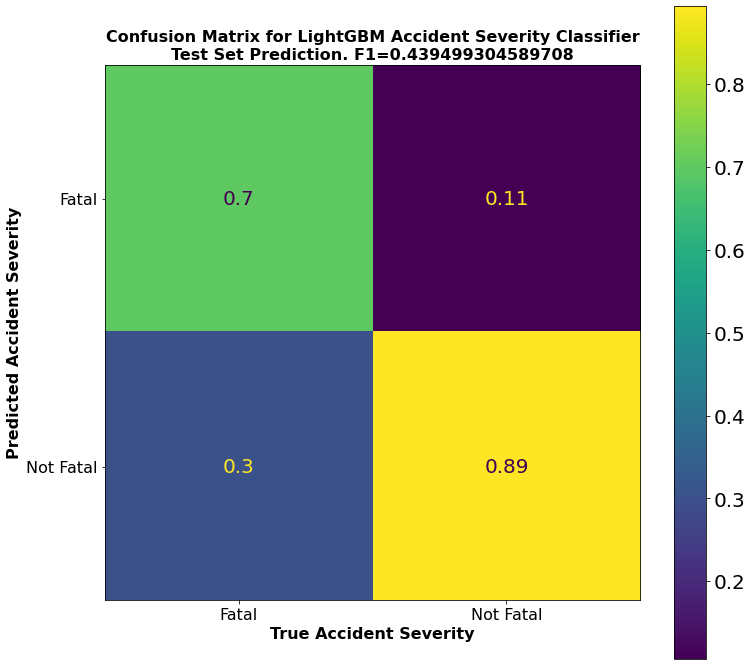

In [237]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Increase the font size for the values displayed inside the confusion matrix
plt.rc('font', **{'size':20})

# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12), squeeze=True)

# Plot the confusion matrix on the axis, using the estimator and test set
ConfusionMatrixDisplay.from_estimator(estimator=rs_severity_lgbm_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      normalize='pred', 
                                      ax=ax)

y_pred = rs_severity_lgbm_clf.predict(X)
predicted_probabilities = rs_severity_lgbm_clf.predict_proba(X)
test_f1 = f1_score(y_true=y, y_pred=y_pred, pos_label="Fatal")

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("True Accident Severity", size=16, weight=1_000)
ax.set_ylabel("Predicted Accident Severity", size=16, weight=1_000)
ax.set_title(f"Confusion Matrix for LightGBM Accident Severity Classifier\nTest Set Prediction. F1={test_f1}", size=16, weight=1_000);

#### Random Forest Accident Severity Classifier

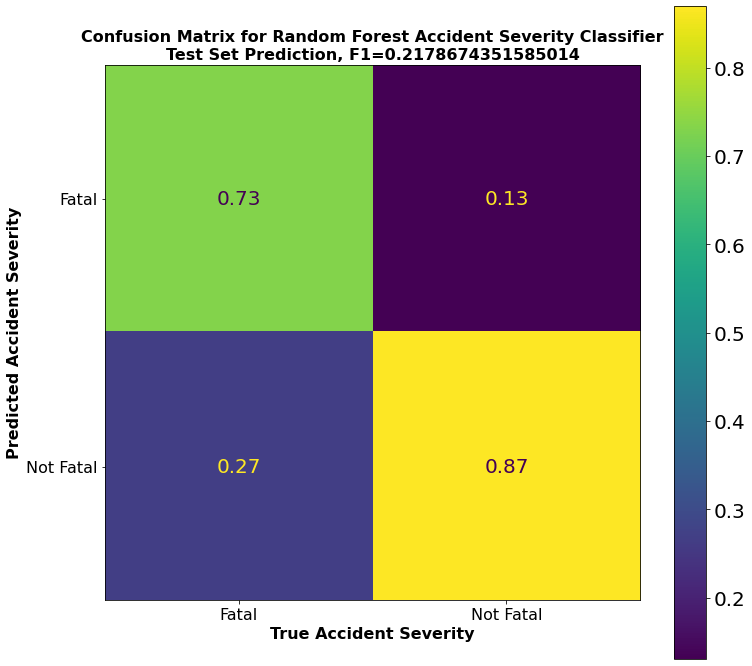

In [238]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Increase the font size for the values displayed inside the confusion matrix
plt.rc('font', **{'size':20})

# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12), squeeze=True)

# Plot the confusion matrix on the axis, using the estimator and test set
ConfusionMatrixDisplay.from_estimator(estimator=rs_severity_rf_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      normalize='pred', 
                                      ax=ax)

y_pred = rs_severity_rf_clf.predict(X)
predicted_probabilities = rs_severity_rf_clf.predict_proba(X)
test_f1 = f1_score(y_true=y, y_pred=y_pred, pos_label="Fatal")

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("True Accident Severity", size=16, weight=1_000)
ax.set_ylabel("Predicted Accident Severity", size=16, weight=1_000)
ax.set_title(f"Confusion Matrix for Random Forest Accident Severity Classifier\nTest Set Prediction, F1={test_f1}", size=16, weight=1_000);

#### KNN Accident Severity Classifier

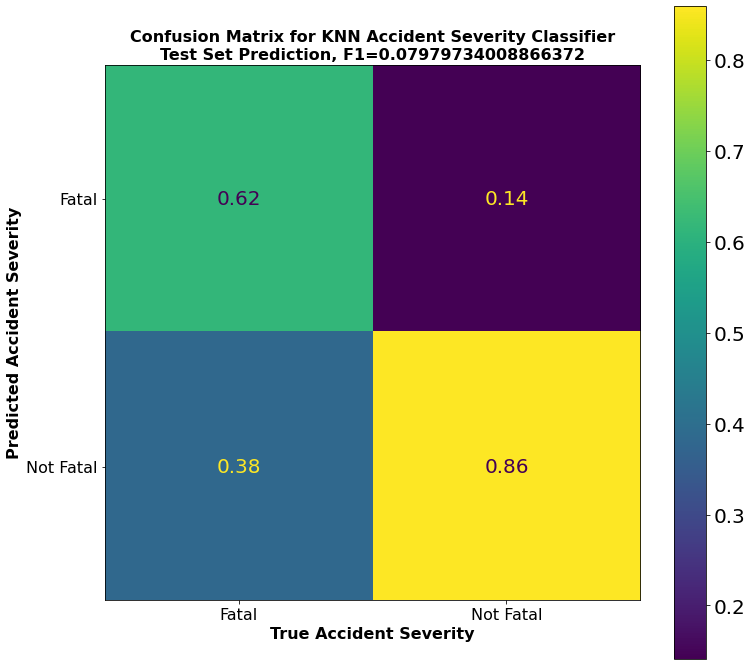

In [239]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Increase the font size for the values displayed inside the confusion matrix
plt.rc('font', **{'size':20})

# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12), squeeze=True)

# Plot the confusion matrix on the axis, using the estimator and test set
ConfusionMatrixDisplay.from_estimator(estimator=rs_severity_knn_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      normalize='pred', 
                                      ax=ax)

y_pred = rs_severity_knn_clf.predict(X)
predicted_probabilities = rs_severity_knn_clf.predict_proba(X)
test_f1 = f1_score(y_true=y, y_pred=y_pred, pos_label="Fatal")

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("True Accident Severity", size=16, weight=1_000)
ax.set_ylabel("Predicted Accident Severity", size=16, weight=1_000)
ax.set_title(f"Confusion Matrix for KNN Accident Severity Classifier\nTest Set Prediction, F1={test_f1}", size=16, weight=1_000);

# Model and Evaluation 5
- Discuss the advantages of each model for each classification task, if any. 
- If there are not advantages, explain why. Is any model better than another? 
- Is the difference significant with 95% confidence? Use proper statistical comparison methods. 
- You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
(10)

## Section Summary

**Accident Severity Classification**
- Advantages for our classification task:  
    - LightGBM: fastest time for fit, wall, CPU as well as best predictive power (F1, AUC) compared to all 3 models  
    - Random forest: compared to kNN, faster wall and CPU time (but slower fit time), better predictive power (F1, AUC) 
    - kNN: faster fit time (but slowest wall and CPU time due to calculating distance in high dimension at predict time)   
- ROC plot and respective AUC values are displayed below
- There is strong evidence to suggest the AUC of lightGBM is significantly different than that of random forest (p-value 1.9e-11 from two sided ttest). 
- We are 95% confident the mean difference in AUC is between .026-.050, our best estimate is .038. 
- That is, lightGBM's AUC is estimated to be 0.038 greater than random forest. 
- View table below to compare AUC estimates and 95% confidence intervals between lightGBM and random forest
- All in all, LightGBM was the winning model based on our declared evaluation metric, F1. We had more confidence in this model when its AUC was statistically greater than the previous two models (random forest, kNN)


**Age Regression:**
- Advantages for our regression task:
    - Random forest: best predictive power (at the cost of train time), best CPU time
    - kNN: better MSE than SGDR, shorter wall time than random forest
    - SGDRegressor: best wall time

In [108]:
chart = [
    [0.849, 0.840, 0.857],
    [0.811, 0.803, 0.819]
]
compare = pd.DataFrame(chart, index = ['LightGBM', 'Random Forest'], columns=['AUC', 'Lower limit', 'Upper limit'])
print('AUC Estimates and 95% Confidence Interval')
compare

AUC Estimates and 95% Confidence Interval


,AUC,Lower limit,Upper limit
LightGBM,0.849,0.840,0.857
Random Forest,0.811,0.803,0.819


## Accident Severity Classification

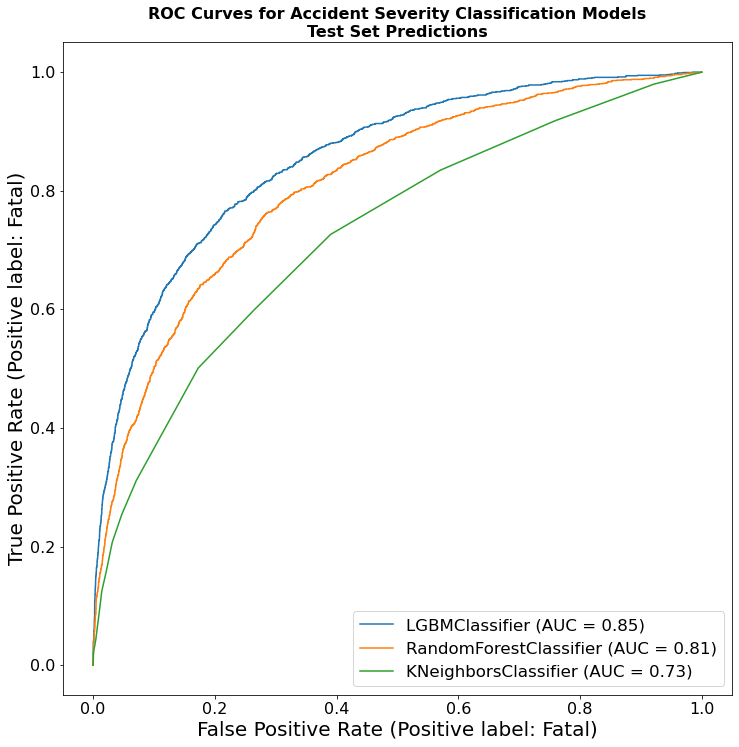

In [241]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]


# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12), squeeze=True)

# Plot the ROC Curve for the LGBM Classifier
RocCurveDisplay.from_estimator(estimator=rs_severity_lgbm_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      ax=ax, pos_label="Fatal")

# Plot the ROC Curve for the RF Classifier
RocCurveDisplay.from_estimator(estimator=rs_severity_rf_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      ax=ax, pos_label="Fatal")

# Plot the ROC Curve for the KNN Classifier
RocCurveDisplay.from_estimator(estimator=rs_severity_knn_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      ax=ax, pos_label="Fatal")

ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize="small")
ax.set_title("ROC Curves for Accident Severity Classification Models\nTest Set Predictions", size=16, weight=1_000);

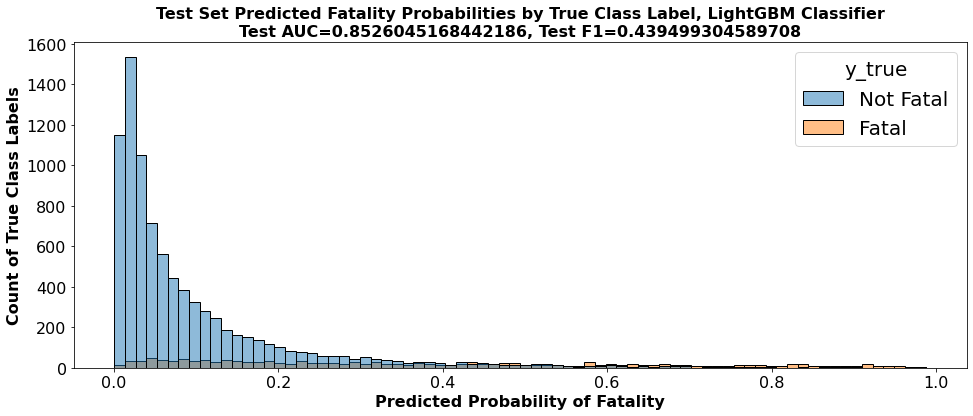

In [242]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Calculate the predicted classes for the test set
y_pred = rs_severity_lgbm_clf.predict(X)

# Calculate predicted class probabilities for the test set
predicted_probabilities = rs_severity_lgbm_clf.predict_proba(X)

# Create a dataframe containing true label, predicted label and class probabilities
lgbm_prediction_df = pd.DataFrame({"y_true":y, 
                                   "y_pred":y_pred, 
                                   "predicted_probability_fatal": predicted_probabilities[:,0], 
                                   "predicted_probability_not_fatal": predicted_probabilities[:,1]})

# Set up the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), squeeze=True)

# Calculate test set AUC and F1
test_auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])
test_f1 = f1_score(y_true=y, y_pred=y_pred, pos_label="Fatal")

# Plot the predicted probability of fatality for each true class label
sns.histplot(data=lgbm_prediction_df, 
             x="predicted_probability_fatal", 
             hue="y_true", 
             ax=ax);

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Predicted Probability of Fatality", size=16, weight=1_000)
ax.set_ylabel("Count of True Class Labels", size=16, weight=1_000)
ax.set_title(f"Test Set Predicted Fatality Probabilities by True Class Label, LightGBM Classifier\nTest AUC={test_auc}, Test F1={test_f1}", size=16, weight=1_000);

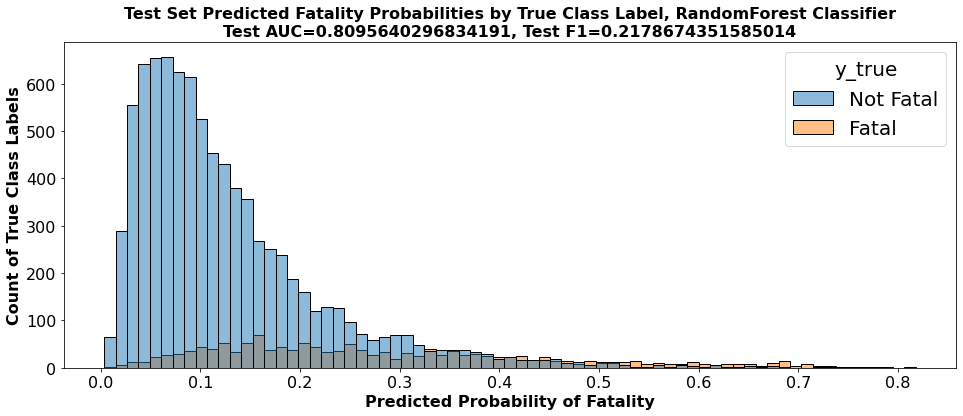

In [243]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

y_pred = rs_severity_rf_clf.predict(X)
predicted_probabilities = rs_severity_rf_clf.predict_proba(X)

rf_prediction_df = pd.DataFrame({"y_true":y, 
                                   "y_pred":y_pred, 
                                   "predicted_probability_fatal": predicted_probabilities[:,0], 
                                   "predicted_probability_not_fatal": predicted_probabilities[:,1]})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), squeeze=True)

test_auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])
test_f1 = f1_score(y_true=y, y_pred=y_pred, pos_label="Fatal")

sns.histplot(data=rf_prediction_df, 
             x="predicted_probability_fatal", 
             hue="y_true", 
             ax=ax);

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Predicted Probability of Fatality", size=16, weight=1_000)
ax.set_ylabel("Count of True Class Labels", size=16, weight=1_000)
ax.set_title(f"Test Set Predicted Fatality Probabilities by True Class Label, RandomForest Classifier\nTest AUC={test_auc}, Test F1={test_f1}", size=16, weight=1_000);

In [113]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Predicted probabilities LightGBM gave to test set observations
predicted_probabilities = rs_severity_lgbm_clf.predict_proba(X)

# Calculate LightGBM AUC on test set
auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])

# This link provides the formula for the standard error of an AUC value
# https://www.real-statistics.com/descriptive-statistics/roc-curve-classification-table/auc-confidence-interval/
n1 = len(y[y == "Not Fatal"])
n2 = len(y[y == "Fatal"])

se_auc_q0 = auc*(1 - auc)
se_auc_q1 = (auc / (2 - auc)) - auc**2
se_auc_q2 = ((2*(auc**2)) /  (1 + auc)) - auc**2

se_auc_lgbm = np.sqrt((se_auc_q0 + (n1 - 1)*se_auc_q1 + (n2-1)*se_auc_q2) / (n1*n2))

# This link provides the justification for the approximate normality of AUC scores (use of critical value from normal)
# https://stats.stackexchange.com/questions/214687/what-statistical-tests-to-compare-two-aucs-from-two-models-on-the-same-dataset
# Critical value for 95% confidence (two-tailed) from a standard normal distribution
z_critical = stats.norm.ppf(q=(0.975))

lgbm_auc_ci_lwr = auc - z_critical*se_auc_lgbm
lgbm_auc_ci_upr = auc + z_critical*se_auc_lgbm
lgbm_auc_center = auc

print("==========================================")
print("95% CI for LightGBM AUC")
print(f"Lower Limit: {lgbm_auc_ci_lwr}")
print(f"Best Estimate: {lgbm_auc_center}")
print(f"Upper Limit: {lgbm_auc_ci_upr}")
print("==========================================")

95% CI for LightGBM AUC
Lower Limit: 0.8443736423780019
Best Estimate: 0.8526045168442186
Upper Limit: 0.8608353913104352


In [114]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Predicted probabilities LightGBM gave to test set observations
predicted_probabilities = rs_severity_rf_clf.predict_proba(X)

# Calculate LightGBM AUC on test set
auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])

# This link provides the formula for the standard error of an AUC value
# https://www.real-statistics.com/descriptive-statistics/roc-curve-classification-table/auc-confidence-interval/
n1 = len(y[y == "Not Fatal"])
n2 = len(y[y == "Fatal"])

se_auc_q0 = auc*(1 - auc)
se_auc_q1 = (auc / (2 - auc)) - auc**2
se_auc_q2 = ((2*(auc**2)) /  (1 + auc)) - auc**2

se_auc_rf= np.sqrt((se_auc_q0 + (n1 - 1)*se_auc_q1 + (n2-1)*se_auc_q2) / (n1*n2))

# This link provides the justification for the approximate normality of AUC scores (use of critical value from normal)
# https://stats.stackexchange.com/questions/214687/what-statistical-tests-to-compare-two-aucs-from-two-models-on-the-same-dataset
# Critical value for 95% confidence (two-tailed) from a standard normal distribution
z_critical = stats.norm.ppf(q=(0.975))

rf_auc_ci_lwr = auc - z_critical*se_auc_lgbm
rf_auc_ci_upr = auc + z_critical*se_auc_lgbm
rf_auc_center = auc

print("==========================================")
print("95% CI for Random Forest AUC")
print(f"Lower Limit: {rf_auc_ci_lwr}")
print(f"Best Estimate: {rf_auc_center}")
print(f"Upper Limit: {rf_auc_ci_upr}")
print("==========================================")

95% CI for Random Forest AUC
Lower Limit: 0.8013331552172025
Best Estimate: 0.8095640296834191
Upper Limit: 0.8177949041496357


In [115]:
# Calculate the variance of the AUC scores for the 
# LightGBM and RandomForest Models
var_auc_rf = se_auc_rf**2
var_auc_lgbm = se_auc_lgbm**2

# Conservative (high) estimate of the variance of the differences in AUCs
# Assumes independence, in which case, 2Cov(AUC_LGBM, AUC_RF) = 0
var_auc_difference = var_auc_lgbm + var_auc_lgbm

# Calculate the standard error for the difference in AUCs
se_auc_difference = np.sqrt(var_auc_difference)

# Calculate the observed difference in AUCs
difference_in_aucs_observed = lgbm_auc_center - rf_auc_center

# The difference in AUCs under the Null Hypothesis
difference_in_aucs_null = 0

# Calculate the test statistic
z_test = (difference_in_aucs_observed - difference_in_aucs_null) / se_auc_difference

# norm.sf = 1 - CDF, giving the probability a value from a normal distribution is greater than z_test
# Since this is a two tailed test, the p-value is 2*(Probability of being greater than Z_test)
p_value = stats.norm.sf(z_test)*2

## Calculate Confidence Interval for difference in AUCs
#
# Critical value for 95% confidence from a normal distribution (two-sided)
z_critical = stats.norm.ppf(q=(0.975))

# Upper and lower limits
auc_diff_ci_lwr = difference_in_aucs_observed - z_critical*se_auc_difference
auc_diff_ci_upr = difference_in_aucs_observed + z_critical*se_auc_difference

print("====================================================================================")
print(f"NULL: LGBM AUC - RF AUC = {difference_in_aucs_null}")
print(f"ALT: LGBM AUC - RF AUC != {difference_in_aucs_null}\n")
print(f"Best Estimate AUC, LGBM: {lgbm_auc_center}")
print(f"Best Estimate AUC, RF: {rf_auc_center}")
print(f"Observed Difference in AUCs: {difference_in_aucs_observed}")
print(f"Standard Error of AUC_lgbm - AUC_rf: {se_auc_difference}\n")
print("Using alpha=0.05, two tails, and standard normal dist.")
print(f"Test Statistic: {z_test}")
print(f"P-Value: {p_value}")
print(f"Hypothesis test conclusion: {'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'}\n")
print(f"95% Confidence Interval for difference in AUCS:")
print(f"Lower Limit, Difference in AUCS: {auc_diff_ci_lwr}")
print(f"Best Estimate, Difference in AUCS: {difference_in_aucs_observed}")
print(f"Upper Limit: {auc_diff_ci_upr}")
print("====================================================================================")

NULL: LGBM AUC - RF AUC = 0
ALT: LGBM AUC - RF AUC != 0

Best Estimate AUC, LGBM: 0.8526045168442186
Best Estimate AUC, RF: 0.8095640296834191
Observed Difference in AUCs: 0.043040487160799445
Standard Error of AUC_lgbm - AUC_rf: 0.0059389939775069695

Using alpha=0.05, two tails, and standard normal dist.
Test Statistic: 7.2471006577559605
P-Value: 4.257875416019435e-13
Hypothesis test conclusion: Reject Null

95% Confidence Interval for difference in AUCS:
Lower Limit, Difference in AUCS: 0.0314002728604855
Best Estimate, Difference in AUCS: 0.043040487160799445
Upper Limit: 0.05468070146111339


## Age Regression

In [244]:
##validate with test set

##OHE maxsev variable on test set

sev_temp=test_pp_df.maxsev_binned
sev_temp=sev_temp.values.reshape(-1,1)
sev_temp_ohe=OneHotEncoder(sparse=False).fit(sev_temp)
test_pp_df[sev_temp_ohe.categories_[0]]=sev_temp_ohe.transform(sev_temp)
test_pp_df

X_test = test_pp_df.drop(columns=["age_im","maxsev_binned"])
y_test = scaler.inverse_transform(test_pp_df.loc[:, ["age_im", "mod_yearname_x"]])[:,0]

##Get Regression model predictions and MSE
rf_reg_preds=rs_age_rf.predict(X_test)
MSE_RF=mean_squared_error(y_test,rf_reg_preds)
knn_reg_preds=rs_age_knn.predict(X_test)
MSE_KNN=mean_squared_error(y_test,knn_reg_preds)
SGD_reg_preds=rs_age_sgdr.predict(X_test)
MSE_SGD=mean_squared_error(y_test,SGD_reg_preds)

##Test Results
#289.2684453461562 MSE for RF
#344.91531631946333 for KNN

# Model and Evaluation 6 
- Which attributes from your analysis are most important? 
- Use proper methods discussed in class to evaluate the importance of different attributes. 
- Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
(10)

## Section Summary

**Accident Severity Classificaton:**
- LightGBM was the winning model based on our declared evaluation metric, F1. We had more confidence in this model when its AUC was statistically greater than the previous two models (random forest, kNN)
- Top 5 features per LightGBM's split importance type: 
    1. Traveling speed
    2. Age of driver
    3. Model year of the vehicle
    4. Whether the driver was speeding or not
    5. Whether the location is urban or rural
- Top 5 features per LightGBM's gain importance:
    1. Traveling speed
    2. Restraint = None (meaning no seatbelt used)
    3. Age of driver
    4. Model year of vehicle
    5. Whether the driver was speeding or not
- Please refer to its respective subheading below for further elaboration and interpretation.

**Age Regression:**
- Random forest was the winning model based on our declared evaluation metric, MSE.
- Top 5 features per Random Forest's Feature Importance  
    1. Traveling speed
    2. Model year of the vehicle
    3. Body type (1)
    4. Sex of driver
    5. Whether the location is urban or rural
- Feature importance is calculated by Gini. Please refer to its respective subheading below for futher elaboration and interpretation.

## Accident Severity Classification

#### LightGBM Feature Importance

Feature importance scores for the best model classification model (LightGBM Classifier) found by RandomSearch. Importance scores using both `importance_type = "split"` and `importance_type = "gain"` are shown below.

Description of `importance_type = "split"`:

The "split", importance score is simply a count of the total number splits the model performed using that particular feature. The interpretation is that the more times the underlying trees that make up the LightGBM classifier picked a given feature to split on, the more important that feature is towards successfully differentiating between the target classes. In the first cell below, we show the top 20 features per the "split" importance type for the best LightGBM classifier found by Random Search. 

Description of `importance_type = "gain"`:

Another feature importance type offered by LightGBM is called "gain". The gain importance is similar to what a RandomForest model using entropy as the criterion for determining split quality would calculate, where the normalized difference in entropy before and after the split is called the gain ratio. The LightGBM gain importance can be interpreted as the average information gain (entropy reduction) that occurs when a particular feature is used in a split. Therefore, a larger gain importance indicates that, on average, a greater reduction in the disorder amongst the class labels occurs when the feature is used in a split. In the second cell below, the best LightGBM classifier found by RandomSearch is refit using all the same hyperparameters, with the `importance_type` updated to `gain`, the output of this cell shows the top 20 features per the "gain" importance type. 

The section summary above lists the top 5 most important feature according to each importance type. We see that these lists have significant overlap, with `traveling speed`, `age`, `vehicle year`, and `speeding vs not speeding` making up 4 of the top 5 most important features per both the `split` and `gain` importance types. We belive that for many people, the fact that these particular features were found to be important would align with their natural intuitions about what factors contribute to the severity of a collision. Some specific hypotheses regarding why these features were important to the LightGBM models performance are as follows: 

- traveling speed: The faster a vehicle is moving at the time of the collision, the greater the likelihood that enough energy to cause significant bodily harm will be transferred to the humans inside the during the crash. Our hypothesis for why this feature was found to be more important than others is due to direct relationship between speed and crash severity. Where some other features, such as weather, act as more of a proxy (poor road conditions, reducing the drivers ability to slow down) for the true factors that determine how bad an accident will be, the speed of vehicle plays a much more direct role in the outcome under study.

- speeding vs not speeding: Speed limits are set based on a variety of factors that assess how fast a vehicle can safely travel on that particular roadway. Our hypothesis for why this feature was found to be more important than many others is that when a driver is violating the speed limit, the same roadway attributes that were used when calculating the roads speed limit (e.g., turns, visibility, proximity to obstacles/pedestrians, etc.) will hinder the drivers ability to take actions that would reduce the severity of the crash (e.g., slow down, swerve). Additionally, the speeding vs not speeding feature is closely related to the traveling speed feature (as traveling speed increases, there is a greater chance that you are speeding), which was found to be the most important feature per both metrics (discussed above).

- restraint = None: There is a much greater chance of being serverely injured during a collision when not wearing a seatbelt. One hypothesis for why this is the case is that, when a seatbelt is properly worn, extremely harmful events such as being ejected from the vehicle are much less likely to occur. We believe the LightGBM classifier may have found this feature to be more important than may others because, for a significant portion of collisions, the difference between a fatal and non-fatal outcome will largely hinge on whether or not the individual was wearing a seat-belt. 

- age of driver: The hypothesis for why driver age was found to be an important feature in determining crash severity is based on three factors, 1) Age may be a good proxy for maturity, which may increase or decrease the chance that a driver will take risky actions that lead to more devasting collisions (e.g., passing a vehicle with low visibility and causing a head on collision). 2) Age may relate to a persons ability to endure a collision without suffering significant injury (e.g., perhaps elderly drivers have more significant injuries than a younger driver would in the same situation). 3) Age may influence a persons reaction time, which would alter their ability to take evasive actions that reduce the severity of a collision (e.g., swerve to avoid a more direct crash).

- model year of vehicle: The hypothesis for why this feature was found to be among the most important is that the model year is a good indicator of what materials were used to build the vehicle. For example, newer vehicles are more likely to be built with more advanced technologies that are designed to keep drivers safe during a collision. Additionally, the year a vehicle was built also gives information about its age, which may be a proxy for the vehicles ability absorb a collision without significant injury to the driver.

- urban vs rural: Our hypothesis for the relatively high importance of the urban vs rural feature is based on several factors. 1) A difference in the average time for first responders to arrive in different geographic locations. For example, a collision of similar magnitude that occurs in a rural area, far away from professionals who can provide quick medical treatment after a crash, would result in a higher recorded crash severity if the individuals involved in the crash die but could have lived had immediate medical treatment been available. 2) Differences in roadway features and traffic laws in different geographic locations. For example, rural areas may be more likely to have higher speed limits, and laws that allow for using the oncoming traffic lane for passing, which can lead to devastating head-on collisions. Similarly, higher speed limits lead to higher traveling speeds, and therefore more severe collisions when crashes occur at these increased speeds. Additionally, rural areas are more likely to have narrower roads and fewer medians which increase the likelihood of more severe collisions.

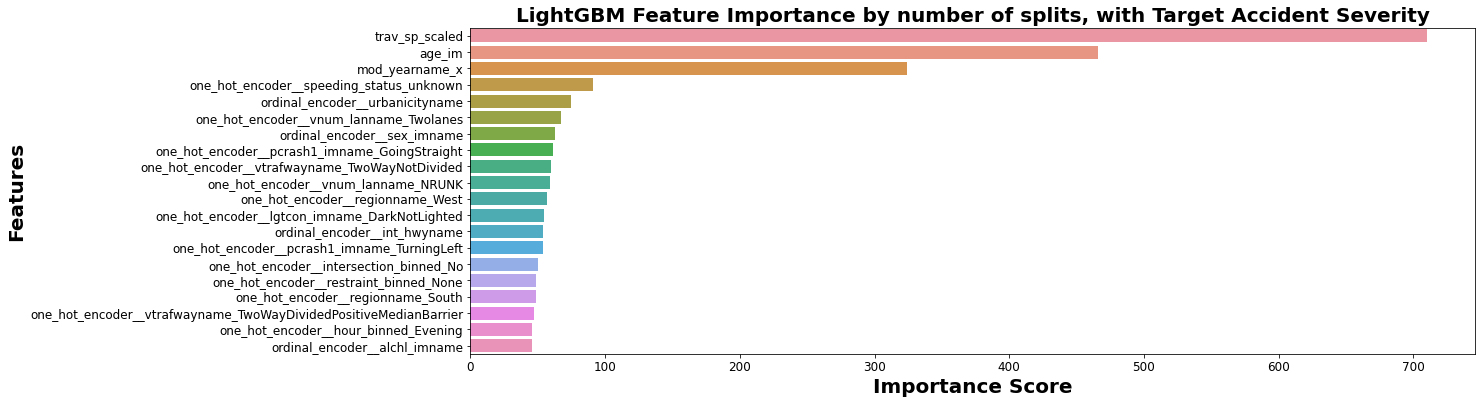

In [245]:
# Plot importances for the top NUM_IMPORTANCES_TO_PLOT features
NUM_IMPORTANCES_TO_PLOT = 20

# Create a dataframe of importance scores
lgbm_importances_df = pd.DataFrame({"feature_name":rs_severity_lgbm_clf.best_estimator_.feature_name_, 
                                    "importance_score":rs_severity_lgbm_clf.best_estimator_.feature_importances_})

# Sort the dataframe, largest to smallest mean score
lgbm_importances_df.sort_values(by="importance_score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
lgbm_importances_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
lgbm_plot_df = lgbm_importances_df.loc[lgbm_importances_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="importance_score", data=lgbm_plot_df, ax=ax, orient="h")

ax.set_title("LightGBM Feature Importance by number of splits, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

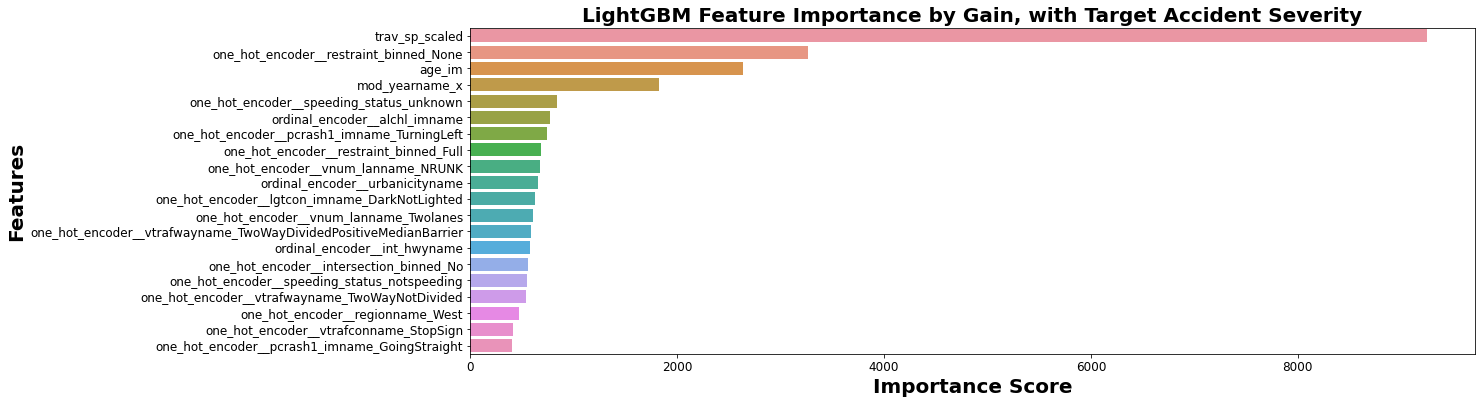

In [247]:
# Plot importances for the top NUM_IMPORTANCES_TO_PLOT features
NUM_IMPORTANCES_TO_PLOT = 20

# Split the train set into X and y
# The extra .rename() is only because LightGBM didn't like some of the characters in the column names. (brackets)
# https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
X = train_pp_df.drop(columns=["maxsev_binned", "Fatal", "Not Fatal"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = train_pp_df.loc[:, "maxsev_binned"]

# Get the parameters for the best model and modify the importance type to gain
params = rs_severity_lgbm_clf.best_estimator_.get_params()
params['importance_type'] = "gain"

# Instantiate and refit the best LGBM Classifier random search found
# Only difference is this time, importance_type="gain" instead of split
best_lgbm_rs_gain = LGBMClassifier(**params)
best_lgbm_rs_gain.fit(X, y)

# Create a dataframe of importance scores
lgbm_importances_gain_df = pd.DataFrame({"feature_name":best_lgbm_rs_gain.feature_name_, 
                                    "importance_score":best_lgbm_rs_gain.feature_importances_})

# Sort the dataframe, largest to smallest mean score
lgbm_importances_gain_df.sort_values(by="importance_score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
lgbm_importances_gain_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
lgbm_gain_plot_df = lgbm_importances_gain_df.loc[lgbm_importances_gain_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="importance_score", data=lgbm_gain_plot_df, ax=ax, orient="h")

ax.set_title("LightGBM Feature Importance by Gain, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

In [248]:
%%time

# Split the test data into X and y
X_train = train_pp_df.drop(columns=["maxsev_binned", "Fatal", "Not Fatal"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate RFECV
rfecv_selector = RFECV(estimator=rs_severity_lgbm_clf.best_estimator_, 
                       step=1, 
                       scoring=make_scorer(f1_score, pos_label="Fatal"),
                       n_jobs=-1)

# Fit RFECV to find the optimal number of features
rfecv_selector.fit(X_train, y_train)

# Create a dataframe of scores for each step of RFECV
rfecv_lgbm_df = pd.DataFrame(rfecv_selector.cv_results_)

# Sort the dataframe, largest to smallest score (mean_test_score = mean_test F1 score, per scorer above).
rfecv_lgbm_df.sort_values(by="mean_test_score", ascending=False, inplace=True)

# Create a list of the optimal features RFECV Found
optimal_features_rfecv = rfecv_selector.feature_names_in_[rfecv_selector.support_]

X_test_all_features = test_pp_df.drop(columns=["maxsev_binned", "Fatal", "Not Fatal"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_test_all_features = test_pp_df.loc[:, "maxsev_binned"]

# Test set predictions, best LightGBM classifier, trained on all features. 
y_pred_all_features = rs_severity_lgbm_clf.best_estimator_.predict(X_test_all_features)
y_pred_probs_all_features = rs_severity_lgbm_clf.best_estimator_.predict_proba(X_test_all_features)

# Test set metrics, best LightGBM classifier, trained on all features. 
auc_test_all_features = roc_auc_score(y_true=y_test_all_features, y_score=y_pred_probs_all_features[:, 1])
f1_test_all_features = f1_score(y_true=y_test_all_features, y_pred=y_pred_all_features, pos_label="Fatal")

# Train set, only containing best features
X_train_best_features = train_pp_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)).loc[:, optimal_features_rfecv.tolist()]
y_train_best_features = train_pp_df.loc[:, "maxsev_binned"]

# Create a clone of the best LightGBM classifier found by RandomSearch. We will use this
# clone to refit the same model using only the best features found by RFECV
best_lgbm = clone(estimator=rs_severity_lgbm_clf.best_estimator_)

# Fit the LightGBM classifier, only using the optimal features found by RFECV
best_lgbm.fit(X_train_best_features, y_train_best_features)

# Test set only containing the best features (the features used when fitting the model in the line above).
X_test_best_features = test_pp_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)).loc[:, optimal_features_rfecv]
y_test_best_features = test_pp_df.loc[:, "maxsev_binned"]

# Test set predictions, best LightGBM classifier, trained on all features. 
y_pred_best_features = best_lgbm.predict(X_test_best_features)
y_pred_probs_best_features = best_lgbm.predict_proba(X_test_best_features)

# Test set metrics, best LightGBM classifier, trained on all features. 
auc_test_best_features = roc_auc_score(y_true=y_test_best_features, y_score=y_pred_probs_best_features[:, 1])
f1_test_best_features = f1_score(y_true=y_test_best_features, y_pred=y_pred_best_features, pos_label="Fatal")

print("=======================================================================================")
print(f"Starting number of features: {len(X_train.columns)}")
print(f"Optimal number of features found by RFECV: {rfecv_selector.n_features_}")
print(f"Mean CV F1 Score with {rfecv_selector.n_features_} features: {rfecv_lgbm_df.reset_index(drop=True).loc[1, 'mean_test_score']}\n")
print(f"Test set metrics using all {len(X_train.columns)} features...")
print(f"Test F1: {f1_test_all_features}")
print(f"Test AUC: {auc_test_all_features}\n")
print(f"Test set metrics using only the best features ({rfecv_selector.n_features_} picked by RFECV)...")
print(f"Test F1: {f1_test_best_features}")
print(f"Test AUC: {auc_test_best_features}\n")
print(f"The best {rfecv_selector.n_features_} found by RFECV were:\n{optimal_features_rfecv}")
print("=======================================================================================")

Starting number of features: 118
Optimal number of features found by RFECV: 85
Mean CV F1 Score with 85 features: 0.4352453997475651

Test set metrics using all 118 features...
Test F1: 0.439499304589708
Test AUC: 0.8526045168442186

Test set metrics using only the best features (85 picked by RFECV)...
Test F1: 0.43678160919540227
Test AUC: 0.8468842059512761

The best 85 found by RFECV were:
['age_im' 'mod_yearname_x' 'ordinal_encoder__urbanicityname'
 'ordinal_encoder__alchl_imname' 'ordinal_encoder__reljct1_imname'
 'ordinal_encoder__int_hwyname' 'ordinal_encoder__sex_imname'
 'one_hot_encoder__hour_binned_Morning'
 'one_hot_encoder__hour_binned_Night'
 'one_hot_encoder__hour_binned_Afternoon'
 'one_hot_encoder__hour_binned_Evening'
 'one_hot_encoder__intersection_binned_Yes'
 'one_hot_encoder__intersection_binned_No'
 'one_hot_encoder__intersection_binned_Other'
 'one_hot_encoder__lgtcon_imname_Daylight'
 'one_hot_encoder__lgtcon_imname_DarkNotLighted'
 'one_hot_encoder__lgtcon_imn

## Age Regression

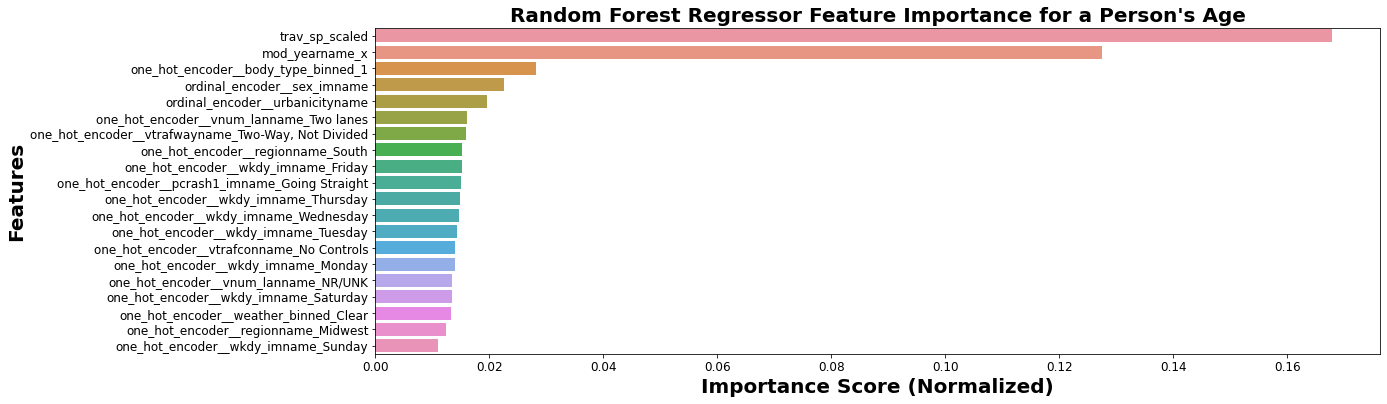

In [249]:
# Plot importances for the top NUM_IMPORTANCES_TO_PLOT features
NUM_IMPORTANCES_TO_PLOT = 20

# Create a dataframe of importance scores
rf_reg_importances_df = pd.DataFrame({"feature_name":rs_age_rf.best_estimator_.feature_names_in_, 
                                    "importance_score":rs_age_rf.best_estimator_.feature_importances_})

# Sort the dataframe, largest to smallest mean score
rf_reg_importances_df.sort_values(by="importance_score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
rf_reg_importances_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
rf_reg_plot_df = rf_reg_importances_df.loc[rf_reg_importances_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="importance_score", data=rf_reg_plot_df, ax=ax, orient="h")

ax.set_title("Random Forest Regressor Feature Importance for a Person's Age", fontsize=20, weight=1000)
ax.set_xlabel("Importance Score (Normalized)", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

The top features for the Random Forest Regressor model are shown in the graph above.  The feature importance is calculated using the Gini Importance Score.  This score is calculated as the difference in the GINI coefficients between a parent node and the node a feature splits on. The score is normalized so that all features' scores will sum to 1.
(See https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_). A larger difference between the nodes shows that the feature split on resulted in a "purer" node, or less error from the target age. 

Travel Speed of the vehicle and Year of the Vehicle are the two features that are prominent for predicting a driver's age in an accident; This goes along with our intuition for the following reasons:

The idiom "Kids will be kids" is a common phrase in our society as children will often fight against societal norms during their teenage years.  Speeding down a road is often one of the defiances teenagers will adopt as they develop their own freedoms from their parents.  As people get older, there is more of a conformity to societal norms for many reasons.  Whether it's facing one's mortality or just the fear of having to pay a speeding ticket, adults seem to drive slower than their teenage counterparts.  This extends into older age as well.  As people enter into their elder years, their reaction times are a lot slower than in their youth and usually take actions much slower. 

With a median household income at $67,521, a car may be a large monthly expense for a person. (See https://www.census.gov/library/publications/2021/demo/p60-273.html)
Many people will want to pay off their car loan and keep the car to decrease the amount of money going out a month.
It tracks then that the older a person is, potentially the older the car is. 
There is also an argument to be made for older cars and younger people.  Many people's first car as a teenager will tend to be a cheaper, older car as teens usually do not have large amounts of income to spend on a newer car. 

The third most important feature in the graph above is our binned feature body type 1, or the binned sedans.  There isn't a lot of intuition behind why this feature is important, however our best guess is that it is the largest category (nearly 20,000 occurrences). However, this feature is where the Importance Score is visibly less than Travel Speed and Model Year. 

The sex of the individual is also another feature that doesn't have a solid explanation as to why it is important.  Our best guess is that males make up a larger population of accidents and it is being split due to that.

Urban/Rural makes a certain level of sense for predicting age of the driver in an accident.  We believe there is a connection between the overall road condition in a rural setting vs an urban setting that would cause people of an older age to have gotten in an accident. Rural settings are also prone to people driving faster as there is more space, less police patrolling per area, and less to hit directly in front of you. 

Comparing to our original feature selection during EDA, the random forest regressor model chose 2 of our original selections, Sedan and Travel Speed.  It adds to our belief that the features are important when different approaches select them. 

# Deployment
(5)

## Task 1: Accident Severity Classification
1. How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?

    The goal of this model is to understand how accident severity is associated with crash factors. Interested parties may be able to use this model to predict fatal accidents in real time. Historical data can be used to identify high-risk areas or times to predict future fatal accidents.

2. How would you measure the model's value if it was used by these parties?

    The model would be successful if provided a basis for change to road infrastructure or policies and general public awareness.

3. How would your deploy your model for interested parties?

    The model could be deployed as a risk map to visualize crash density in the US.

4. What other data should be collected? How often would the model need to be updated, etc.?

    GPS data could be collected to obtain a more granular understanding of at-risk locations. The model would ideally be updated as new traffic information comes in but is perhaps at the mercy of memory and computational power.

## Task 2: Age Regression
1. How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?

    This model is used for multivariate **inference**, notably to assess effect of age on crash involvement and fatality. 

2. How would you measure the model's value if it was used by these parties?

    The model would be successful if it acted as foundational base for public awareness and policy changes. 

3. How would your deploy your model for interested parties?

    Model deployment would be in some visual form, perhabs on Tableau for leadership and public consumption.

4. What other data should be collected? How often would the model need to be updated, etc.?

    Additional location, traffic, or accident data could be collected in conjunction. Because this is an inferential model, it does not need to be updated as often, though on a quarterly basis is ideal.

# Exceptional Work
- You have free reign to provide additional analyses. 
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. 
- Which parameters are most significant for making a good model for each classification algorithm?
(10)

**Section Summary**
- SKL's GridSearchCV was utilized for LightGBM to classify accident severity for categorical response variable, `maxsev_binned` (fatal or not fatal) using the same train/test data and 10 fold internal stratified cross validation previously done
- Metrics of interest are F1 and AUC, elucidated on the hold out test set
- Listed below are the hyperparameter tunings:  

    'boosting_type':['dart', 'gbdt']  
    'num_leaves': [25, 31, 41, 46]  
    'min_child_samples':[15, 20]  
    'n_estimators':[100, 300, 600, 650]  
    'subsample' : [0.9, 1.0]   
    'colsample_bytree' : [0.9, 1.0]    
    'learning_rate' : [0.05, 0.1, 0.3, 0.4, 0.45]  

- The hyperparameters of the best performing model is:
- Below is a table comparing performance from LightGBM and LightGBM through GridSearch. The latter method appears to motivate a slightly better F1 metric at the cost of train time.

In [127]:
chart = [
    [0.45, 0.85, 0.88, 1.23],
    [0.50, 0.85, 0.88, 5.02]
]
compare = pd.DataFrame(chart, index = ['LightGBM', 'LightGBM (GridSearchCV)'], columns=['F1', 'AUC', 'Accuracy', 'Fit time'])
print('Metrics for Accident Severity Classification')
compare

Metrics for Accident Severity Classification


,F1,AUC,Accuracy,Fit time
LightGBM,0.45,0.85,0.88,1.23
LightGBM (GridSearchCV),0.50,0.85,0.88,5.02


In [119]:
# grid search code
# Split the train set into X and y
# The extra .rename() is only because LightGBM didn't like some of the characters in the column names. (brackets)
# https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
X = train_pp_df.drop(columns=["maxsev_binned", "Fatal", "Not Fatal"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = train_pp_df.loc[:, "maxsev_binned"]


parameter_grid = {'boosting_type':['dart', 'gbdt'],
                  'num_leaves': [25, 31, 41, 46],
                  'min_child_samples':[15, 20],
                   'n_estimators':[100, 300, 600, 650],
                   'subsample' : [0.9, 1.0],                    # Enable random selection of training cases (rows).
                   'colsample_bytree' : [0.9, 1.0],             # Percentage of features to randomly consider at each split.
                   'learning_rate' : [0.05, 0.1, 0.3, 0.4, 0.45]}


gs = GridSearchCV(estimator=LGBMClassifier(random_state=42),
                  param_grid=parameter_grid,
                  scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)},
                  refit="f1",
                  n_jobs=-1, 
                  cv=10,
                  verbose=1, 
                  error_score='raise', 
                  return_train_score=True)

gs.fit(X, y)


# Split the test set
X_test = test_pp_df.drop(columns=["maxsev_binned", "Fatal", "Not Fatal"]).rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_test = test_pp_df.loc[:, "maxsev_binned"]

# Predict on the test set
y_pred = gs.predict(X_test)
y_pred_score = gs.predict_proba(X_test)

# Calculate test set AUC and F1 on the test set
test_auc = roc_auc_score(y_true=y_test, y_score=y_pred_score[:,1])
test_f1 = f1_score(y_true=y_test, y_pred=y_pred, pos_label="Fatal")

print(f"test set auc: {test_auc}, test set f1: {test_f1}")

Fitting 10 folds for each of 1280 candidates, totalling 12800 fits
test set auc: 0.8515193570632275, test set f1: 0.4969801553062986


In [126]:
print(f"Test set accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}")

Test set accuracy: 0.8846344117938063


In [263]:
gs.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9,
 'importance_type': 'split',
 'learning_rate': 0.4,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 600,
 'n_jobs': -1,
 'num_leaves': 25,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [120]:
gs_df = pd.DataFrame(gs.cv_results_)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in gs_df.columns if column not in first_columns]
gs_df = gs_df.loc[:, new_column_order]

gs_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

gs_df

,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_colsample_bytree,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,std_train_accuracy
881,0.481192,0.989828,0.879168,0.997056,5.029756,0.690921,0.261999,0.060528,gbdt,0.9,...,0.997059,0.997526,0.996619,0.997252,0.997087,0.996922,0.997032,0.997032,0.997444,0.000289
880,0.481192,0.989828,0.879168,0.997056,4.960262,0.657065,0.222884,0.019493,gbdt,0.9,...,0.997059,0.997526,0.996619,0.997252,0.997087,0.996922,0.997032,0.997032,0.997444,0.000289
825,0.481157,0.973849,0.881814,0.992541,4.695319,0.235396,0.222398,0.013579,gbdt,0.9,...,0.992909,0.992140,0.992882,0.991810,0.991947,0.992827,0.992937,0.992854,0.993212,0.000501
824,0.481157,0.973849,0.881814,0.992541,5.196408,0.575375,0.232500,0.021650,gbdt,0.9,...,0.992909,0.992140,0.992882,0.991810,0.991947,0.992827,0.992937,0.992854,0.993212,0.000501
1177,0.481130,0.994410,0.879366,0.998376,5.105171,0.368163,0.249366,0.031841,gbdt,1.0,...,0.998049,0.998626,0.998461,0.998049,0.998406,0.998076,0.998351,0.998049,0.998763,0.000306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,0.222389,0.231521,0.864005,0.865341,2.462129,0.346634,0.081900,0.014536,dart,1.0,...,0.866209,0.865054,0.865741,0.864395,0.865989,0.864944,0.865109,0.865140,0.866570,0.000724
352,0.221352,0.230881,0.863857,0.865291,2.038966,0.090805,0.072600,0.006800,dart,1.0,...,0.866236,0.864862,0.865522,0.865027,0.865989,0.864642,0.865467,0.864536,0.866130,0.000635
353,0.221352,0.230881,0.863857,0.865291,2.021897,0.067531,0.071200,0.004600,dart,1.0,...,0.866236,0.864862,0.865522,0.865027,0.865989,0.864642,0.865467,0.864536,0.866130,0.000635
32,0.220056,0.229409,0.863906,0.865289,2.082131,0.077465,0.074300,0.008186,dart,0.9,...,0.865329,0.865247,0.865796,0.865109,0.865686,0.865302,0.865384,0.864453,0.866460,0.000624


# Appendix
Data dictionary referenced from [CRSS Analytical Users Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813236)